### Background
- Необходимость сократить время на осуществление относительно простых, но в тоже время рутинных и часто возникающих CFD-расчетов трубопроводов различного назначения

### Purpose
- Оценить состоятельность и эффективность применения Deep Convolutional Neural Networks для решения поставленной задачи, а также общие трудо- и время- затраты (на обучение модели и т.д.)
- Применить полученные на курсе знания и навыки для решения практической (насущной) задачи
- Получить новый опыт

---
- `FinalProject_ModelListGeneration.py` - скрипт генерации параметров геометрии CFD моделей
- `FinalProject_CadModelGeneration.ipynb` - скрипт генерации CAD моделей по параметрам
- `FinalProject_CfdModelGeneration.FCMacro` - скрипт генерации CFD моделей из CAD
- `runALLAllmesh`, `runALLAllrun` - скрипты запуска генерации расчетной сетки и запуска CFD расчета
- `FinalProject_GettingResults_v1.py` - скрипт извлечения результатов



[DATA EXAMPLES](https://drive.google.com/drive/folders/1BUo5T81UsoqGpVlbbAevScY0er5NXZrp?usp=sharing)

---

In [ ]:
# from platform import python_version

# print(python_version())

In [1]:
# libraries importing
import os, glob, itertools, re, pickle, json, random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm, trange

from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from FinalProject_ModelListGeneration import get_models_list

In [2]:
# environment setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
DATA_PATH = 'D:\\DataScience\\FinalProject\\cfd_results\\10mm'

## Data importing

### Tabular data

In [ ]:
# # getting list with models parameters
# models = get_models_list()

# models = models[models['diameter']==10]
# models.reset_index(drop=True, inplace=True)
# models.drop(columns=['diameter'], inplace=True)

# display(models.head(3), models.shape)

In [ ]:
# # getting cfd-analysis tabular results data
# tables_list = glob.glob(os.path.join(DATA_PATH, '*', '*.csv'))

# for i, table in enumerate(tables_list):
#     if i == 0:
#         results = pd.read_csv(table)
#     else:
#         results = results.append(pd.read_csv(table), ignore_index=True)

# display(results.head(3), results.shape)

In [ ]:
# # concatenate data (parameters + cfd-results)
# models = models.merge(results, how='right', on='description')

# display(models.head(3), models.shape)

#### Preprocessing

- Для обучения нейросети будем использовать отдельно каждую "секцию" по отдельности со своими распределениями скоростей и давления на входном и выходном сечениях. Так же "дадим модели знать" о параметрах предыдущей и последующей секциях.

In [ ]:
# # list of necessary data for learning
# data = {'before_size':[],
#         'before_shape':[],
#         'before_direction':[],
#         'current_size':[],
#         'current_shape':[],
#         'current_direction':[],
#         'after_size':[],
#         'after_shape':[],
#         'after_direction':[],
#         'inlet-P_min':[],
#         'inlet-P_max':[],
#         'inlet-UX_min':[],
#         'inlet-UX_max':[],
#         'inlet-UY_min':[],
#         'inlet-UY_max':[],
#         'inlet-UZ_min':[],
#         'inlet-UZ_max':[],
#         'outlet-P_min':[],
#         'outlet-P_max':[],
#         'outlet-UX_min':[],
#         'outlet-UX_max':[],
#         'outlet-UY_min':[],
#         'outlet-UY_max':[],
#         'outlet-UZ_min':[],
#         'outlet-UZ_max':[]
#        }

In [ ]:
# # getting each section of model as one data row
# for i in range(len(models)):
    
#     section_count = int((len(models['description'][i].split('-'))-1)/3)
    
#     '''
#     Getting parameters of current section and also previous and next sections.
#     If section is first or last set 0 for the all parameters of
#     previous or next section respectively.
#     '''
#     for j in range(section_count):
#         for x in range(0,7,3):
#             for y,column in enumerate(list(data.keys())[x:x+3]):
#                 if x == 3:
#                     data[column].append(models.iloc[i, j+3*y])
#                 elif x == 0:
#                     if j == section_count-1 or j == 0:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j-1+3*y])
#                 else:
#                     if j == section_count-1:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j+1+3*y])
        
#         '''
#         Getting results of section INLET and OUTLET
#         '''
#         inlet_idx = 's'+str(j)
#         outlet_idx = 's'+str(j+1)
        
#         d = {'inlet':inlet_idx,
#              'outlet':outlet_idx}
        
#         cnt = 0
        
#         for column in list(data.keys())[9:25]:
#             cnt += 1
#             result = column.split('-')
#             data[column].append(models[d[result[0]]+'-'+result[1]][i])
            
#             ## getting path to images 
#             if cnt % 2 == 0:
#                 result[1] = result[1].split('_')[0]
                
#                 new_column = result[0]+'-'+result[1]+'_image'
#                 img_name = d[result[0]]+'-'+result[1]+'.png'
#                 path2img = glob.glob(os.path.join(DATA_PATH, '*', models['description'][i], img_name))[0]
                
#                 if new_column not in list(data.keys()):
#                     data[new_column] = []
#                 data[new_column].append(path2img)

In [ ]:
# df = pd.DataFrame(data)

# display(df.head(3), df.shape)

In [ ]:
# df.info()

In [ ]:
# # Lable encoding
# encoder = LabelEncoder()

# for column in list(df.columns)[:-int(cnt/2)]:
#     if df[column].dtypes == 'O':
#         df[column] = df[column].apply(str)
#         df[column] = encoder.fit_transform(df[column])

# display(df.head(3), df.shape)

- Дабы при каждом перезапуске не проводить преобразование выше, сохраним датафрейм и далее будем подгружат данные из него

In [ ]:
# df.to_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'), index=False)

In [4]:
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))
display(df.head(3), df.shape)

before_size  before_shape  before_direction  current_size  current_shape  \
0            0             0                 0         100.0              0   
1            0             0                 0         100.0              1   
2            0             0                 0         100.0              2   

   current_direction  after_size  after_shape  after_direction  inlet-P_min  \
0                  1         0.0            0                0     2.883144   
1                  1         0.0            0                0    15.469522   
2                  1         0.0            0                0    12.722014   

   inlet-P_max  inlet-UX_min  inlet-UX_max  inlet-UY_min  inlet-UY_max  \
0    23.250622     -0.000076      0.000062     -0.000057      0.000062   
1    31.255623      0.000000      0.000000      0.000000      0.000000   
2    17.040760      0.000000      0.000000      0.000000      0.000000   

   inlet-UZ_min  inlet-UZ_max  outlet-P_min  outlet-P_max  outlet-UX_min  \
0     10.649561     10.649561           0.0           0.0       3.521138   
1     10.645368     10.645368           0.0           0.0       3.197995   
2     10.645036     10.645036           0.0           0.0      -0.028793   

   outlet-UX_max  outlet-UY_min  outlet-UY_max  outlet-UZ_min  outlet-UZ_max  \
0       7.946285      -0.548229       0.546499       3.477491       8.726934   
1      12.199653      -0.741741       0.741699      -1.062204       0.769829   
2       0.026809      -0.028804       0.026948       6.384067      11.541277   

                                       inlet-P_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UX_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UY_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      inlet-UZ_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                      outlet-P_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UX_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UY_image  \
0  D:\DataScience\FinalProject\cfd_results\10mm\1...   
1  D:\DataScience\FinalProject\cfd_results\10mm\1...   
2  D:\DataScience\FinalProject\cfd_results\10mm\1...   

                                     outlet-UZ_image  
0  D:\DataScience\FinalProject\cfd_results\10mm\1...  
1  D:\DataScience\FinalProject\cfd_results\10mm\1...  
2  D:\DataScience\FinalProject\cfd_results\10mm\1...

(6024, 33)

In [ ]:
df.info()

In [ ]:
rslt = list(df.columns)[9:-8]

n_rslt = len(rslt)

fig, axs = plt.subplots(int(n_rslt/2), 2, figsize=(20, n_rslt*3))

for i, j in enumerate(rslt):
    min_value=round(df[j].min(), 1)
    max_value=round(df[j].max(), 1)

    axs[i//2][i%2].hist(df[j], bins='auto')
    axs[i//2][i%2].set_title(f'{j}: Min.val.={min_value}, Max.val.={max_value}')
    axs[i//2][i%2].grid(True, axis='y', alpha=0.5)
    axs[i//2][i%2].set_ylabel('Count')

### Image data

In [ ]:
def get_img_samples(n_smpl=5, df=df, s_sart=-8, s_end=None):

    plt.figure(figsize=(20, n_smpl*2))

    for i, (x, y) in enumerate(itertools.product(df.sample(n_smpl).index, list(df.columns)[s_sart:s_end])):
        file_name = df[y][x]
        img = Image.open(file_name)
        plt.subplot(n_smpl, 8, i+1)
        plt.imshow(img)
        plt.title(f"{x}-{y}")
        plt.axis('off')

    plt.show()

In [ ]:
get_img_samples()

#### Preprocessing

In [ ]:
img_path = df['inlet-P_image'][2924]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img)

In [ ]:
print(f"Max.val.= {df['inlet-P_max'][2924]},\nMin.val.= {df['inlet-P_min'][2924]}")

In [46]:
def get_preprocessed_image(column, row, ratio=4, df=df, save=False, data_path=DATA_PATH):
    
    '''loading image'''
    img_path = df[column][row]
    # as single channel image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # downsizing
    img_h, img_w = img.shape
    assert img_h % ratio == 0 and img_w % ratio == 0, 'Image size must be even divisible by resizing ratio'
    new_size = (img_w//ratio, img_h//ratio)
    img_changed = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    
    # normalize pixels value (optional)
    img_changed = img_changed/255

    '''scaling'''
    img_h, img_w = img_changed.shape
    # values range
    max_val = df[column.replace('image', 'max')][row]
    min_val = df[column.replace('image', 'min')][row]
    # pixels value range
    max_val_px = np.unique(img_changed)[-1]
    min_val_px = np.unique(img_changed)[1]

    '''set real value as pixel grey value'''
    for h, w in list(itertools.product(range(img_h), range(img_w))):
        '''
        If a pixel has a value of 0, it means that it is outside the pipe cross section
        Set it to the value of atmospheric pressure, in the case of CFD analysis equal to 0.
        '''
        if img_changed.item(h, w) != 0:
            real_val = (img_changed.item(h, w)-min_val_px)\
                        * (max_val-min_val)/(max_val_px-min_val_px) + min_val
        else:
            real_val = 0

        img_changed.itemset((h, w), real_val / 127.5)

    '''saving preprocessed image, if required'''
    if save:
        found_names = re.findall(r"\d+.+?[^\\]*", img_path)
        batch_name = found_names[1]
        model_name = found_names[2]
        img_name = os.path.basename(img_path)

        save_path = os.path.join(data_path.replace('cfd_results', 'img_preprocessing'),
                                 batch_name,
                                 model_name)
        os.makedirs(save_path, exist_ok=True)
        '''
        The adding 127.5 to each pixel shifts the zero to a mid-grey value,
        shows negative values as darker, and positive values as lighter.
        '''
        cv2.imwrite(os.path.join(save_path, img_name), img_changed + 127.5)

    return np.array(img_changed.astype('float32')), img_h, img_w

---
##### Checking function work

In [ ]:
img_changed, _, _ = get_preprocessed_image(column='inlet-P_image',
                                           row=2924)

# plt.figure(figsize=(20,20))
plt.imshow(img_changed, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img_changed)

---

In [ ]:
# Lable encoding
encoder = LabelEncoder()

for column in list(df.columns):
    if 'size' in column:
        df[column] = df[column].apply(int)
        df[column] = encoder.fit_transform(df[column])

display(df.head(3), df.shape)

In [ ]:
# def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
#     h = img_h//3 + 1
#     w = img_w//3 + 1
    
#     '''create filled with zeros array'''
#     s = (img_h, img_w)
#     geom_param = np.zeros(s)
    
#     '''fill by previous geom'''
#     geom_param[:] = df[list(df.columns)[0]][row]
#     geom_param[:,w:] = df[list(df.columns)[1]][row]
#     geom_param[:,-w:] = df[list(df.columns)[2]][row]
    
#     '''fill by current geom'''
#     geom_param[h:] = df[list(df.columns)[3]][row]
#     geom_param[h:,w:] = df[list(df.columns)[4]][row]
#     geom_param[h:,-w:] = df[list(df.columns)[5]][row]
    
#     '''fill by next geom'''
#     geom_param[-h:] = df[list(df.columns)[6]][row]
#     geom_param[-h:,w:] = df[list(df.columns)[7]][row]
#     geom_param[-h:,-w:] = df[list(df.columns)[8]][row]
    
#     return geom_param.astype('float32')

In [ ]:
def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    for (h, w), i in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(list(df.columns)[:9])):
        geom_param.itemset((h, w), df[i][row])
    
    return geom_param.astype('float32')

---
##### Checking function work

In [ ]:
df.iloc[2924]

In [ ]:
geom_param = get_geom_channel(2924)

# plt.figure(figsize=(20,20))
plt.imshow(geom_param, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(geom_param)

---
## Dataset preparing

In [ ]:
def get_channels_set(column_list, row, df=df, with_geom=True):
    
    channels_set = []
    
    for column in column_list:
        value_channel, img_h, img_w = get_preprocessed_image(column=column,
                                                             row=row,
                                                             df=df)
        channels_set.append(value_channel)
    
    if with_geom:
        geom_channel = get_geom_channel(row=row,
                                        df=df,
                                        img_h=img_h,
                                        img_w=img_w)
        channels_set.append(geom_channel)

    return channels_set

In [ ]:
dataset_lists = {'dataX_model_V':[['inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], True],
                 
                 'dataX_model_P':[['outlet-P_image',
                                   'inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], False],
                 
                 'dataY_model_V':[['outlet-UX_image',
                                   'outlet-UY_image',
                                   'outlet-UZ_image'], False],
                 
                 'dataY_model_P':[['inlet-P_image'], False]}

In [ ]:
for ds in list(dataset_lists.keys()):

    data = Parallel(n_jobs=-1)(delayed(get_channels_set)(column_list=dataset_lists[ds][0],
                                                         with_geom=dataset_lists[ds][1],
                                                         row=row) for row in trange(len(df)))
    f = open(ds + '.pkl', 'wb')
    pickle.dump(data, f)
    f.close()
    del data

---
##### Checking function work

In [ ]:
x = pickle.load(open("dataX_model_V.pkl", "rb"))

plt.figure(figsize=(20,4))

for i in range(len(x[0])):
    plt.subplot(1, len(x[0]), i+1)
    plt.imshow(x[2924][i], cmap='gray')
    plt.colorbar()

---

# DCNN

In [5]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

import copy

In [6]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design (UUID: GPU-05df1c92-ad9b-711e-a79e-eaa2ef54918a)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

### Helper functions

In [8]:
def split_tensors(*tensors, ratio):
    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

In [9]:
def create_layer(in_channels,
                 out_channels,
                 kernel_size,
                 wn=True,
                 bn=True,
                 activation=nn.ReLU,
                 convolution=nn.Conv2d):

    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels,
                       out_channels,
                       kernel_size,
                       padding=kernel_size//2)
    if wn:
        conv = weight_norm(conv)
    
    layer.append(conv)
    
    if activation is not None:
        layer.append(activation())
    
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layer)

In [10]:
def create_encoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2):
    
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

In [11]:
def create_decoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2,
                         final_layer=False):
    
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

In [12]:
def create_encoder(in_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels,
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        else:
            encoder_layer = create_encoder_block(filters[i-1],
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

In [13]:
def create_decoder(out_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i],
                                                 out_channels,
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i],
                                                 filters[i-1],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

In [14]:
def initialize(model, gain=1, std=0.02):
    for module in model.modules():
        if type(module) in [nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d]:
            nn.init.xavier_normal_(module.weight, gain)
            if module.bias is not None:
                nn.init.normal_(module.bias, 0, std)

In [15]:
def epoch(scope, loader, on_batch=None, training=False):
    model = scope["model"]
    optimizer = scope["optimizer"]
    loss_func = scope["loss_func"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)
    scope["loader"] = loader

    metrics_list = generate_metrics_list(metrics_def)
    total_loss = 0
    if training:
        model.train()
    else:
        model.eval()
    for tensors in loader:
        
        if "process_batch" in scope and scope["process_batch"] is not None:
            tensors = scope["process_batch"](tensors)
        if "device" in scope and scope["device"] is not None:
            tensors = [tensor.to(scope["device"]) for tensor in tensors]
            
        loss, output = loss_func(model, tensors)
        
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item()
        
        scope["batch"] = tensors
        scope["loss"] = loss
        scope["output"] = output
        scope["batch_metrics"] = {}
        
        for name, metric in metrics_def.items():
            value = metric["on_batch"](scope)
            scope["batch_metrics"][name] = value
            metrics_list[name].append(value)
        if on_batch is not None:
            on_batch(scope)
    scope["metrics_list"] = metrics_list
    metrics = {}
    for name in metrics_def.keys():
        scope["list"] = scope["metrics_list"][name]
        metrics[name] = metrics_def[name]["on_epoch"](scope)
    return total_loss, metrics

In [16]:
def train(scope,
          train_dataset,
          val_dataset,
          patience=10,
          batch_size=256,
          print_function=print,
          eval_model=None,
          on_train_batch=None,
          on_val_batch=None,
          on_train_epoch=None,
          on_val_epoch=None,
          after_epoch=None):
    
    epochs = scope["epochs"]
    model = scope["model"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)

    scope["best_train_metric"] = None
    scope["best_train_loss"] = float("inf")
    scope["best_val_metrics"] = None
    scope["best_val_loss"] = float("inf")
    scope["best_model"] = None

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    skips = 0
    
    for epoch_id in range(1, epochs + 1):
        scope["epoch"] = epoch_id
        print_function("Epoch #" + str(epoch_id))
        
        # Training
        scope["dataset"] = train_dataset
        train_loss, train_metrics = epoch(scope, train_loader, on_train_batch, training=True)
        scope["train_loss"] = train_loss
        scope["train_metrics"] = train_metrics
        print_function("\tTrain Loss = " + str(train_loss))
        
        for name in metrics_def.keys():
            print_function("\tTrain " + metrics_def[name]["name"] + " = " + str(train_metrics[name]))
        if on_train_epoch is not None:
            on_train_epoch(scope)
        del scope["dataset"]
        
        # Validation
        scope["dataset"] = val_dataset
        with torch.no_grad():
            val_loss, val_metrics = epoch(scope, val_loader, on_val_batch, training=False)
        scope["val_loss"] = val_loss
        scope["val_metrics"] = val_metrics
        print_function("\tValidation Loss = " + str(val_loss))
        
        for name in metrics_def.keys():
            print_function("\tValidation " + metrics_def[name]["name"] + " = " + str(val_metrics[name]))
        if on_val_epoch is not None:
            on_val_epoch(scope)
        del scope["dataset"]
        
        # Selection
        is_best = None
        if eval_model is not None:
            is_best = eval_model(scope)
        if is_best is None:
            is_best = val_loss < scope["best_val_loss"]
        if is_best:
            scope["best_train_metric"] = train_metrics
            scope["best_train_loss"] = train_loss
            scope["best_val_metrics"] = val_metrics
            scope["best_val_loss"] = val_loss
            scope["best_model"] = copy.deepcopy(model)
            print_function("Model saved!")
            skips = 0
        else:
            skips += 1
        if after_epoch is not None:
            after_epoch(scope)

    return scope["best_model"],\
           scope["best_train_metric"],\
           scope["best_train_loss"],\
           scope["best_val_metrics"],\
           scope["best_val_loss"]

In [17]:
def train_model(model,
                loss_func,
                train_dataset,
                val_dataset,
                optimizer,
                process_batch=None,
                eval_model=None,
                on_train_batch=None,
                on_val_batch=None,
                on_train_epoch=None,
                on_val_epoch=None,
                after_epoch=None,
                epochs=100,
                batch_size=256,
                patience=10,
                device=0,
                **kwargs):
    
    model = model.to(device)
    
    scope = {}
    scope["model"] = model
    scope["loss_func"] = loss_func
    scope["train_dataset"] = train_dataset
    scope["val_dataset"] = val_dataset
    scope["optimizer"] = optimizer
    scope["process_batch"] = process_batch
    scope["epochs"] = epochs
    scope["batch_size"] = batch_size
    scope["device"] = device
    metrics_def = {}
    names = []
    
    for key in kwargs.keys():
        parts = key.split("_")
        if len(parts) == 3 and parts[0] == "m":
            if parts[1] not in names:
                names.append(parts[1])
    
    for name in names:
        if "m_" + name + "_name" in kwargs and "m_" + name + "_on_batch" in kwargs and "m_" + name + "_on_epoch" in kwargs:
            metrics_def[name] = {
                "name": kwargs["m_" + name + "_name"],
                "on_batch": kwargs["m_" + name + "_on_batch"],
                "on_epoch": kwargs["m_" + name + "_on_epoch"],
            }
        else:
            print("Warning: " + name + " metric is incomplete!")
    scope["metrics_def"] = metrics_def
    
    return train(scope,
                 train_dataset,
                 val_dataset,
                 eval_model=eval_model,
                 on_train_batch=on_train_batch,
                 on_val_batch=on_val_batch,
                 on_train_epoch=on_train_epoch,
                 on_val_epoch=on_val_epoch,
                 after_epoch=after_epoch,
                 batch_size=batch_size,
                 patience=patience)

In [18]:
def generate_metrics_list(metrics_def):
    list = {}
    for name in metrics_def.keys():
        list[name] = []
    return list

In [19]:
def visualize(sample_y, out_y, error):
    
    var_list = [sample_y, out_y, error]
    title_list = ['CFD', 'CNN', 'Error']
    lable_list = ['Ux', 'Uy', 'Uz']

    output_size = len(out_y) #10
    output_channels = len(out_y[0]) #3

    smpl = random.randint(0, output_size-1)
    
    print(f'Sampled model number: {smpl}')

    plt.figure(figsize=(20, output_channels*5))
    
    cnt = 0

    for i in range(output_channels):

        vmin_sample = np.min(sample_y[smpl, i, :, :])
        vmax_sample = np.max(sample_y[smpl, i, :, :])

        vmin_out = np.min(out_y[smpl, i, :, :])
        vmax_out = np.max(out_y[smpl, i, :, :])
        
        vmin_error = np.min(error[smpl, i, :, :])
        vmax_error = np.max(error[smpl, i, :, :])

        for j in range(3):
            
            cnt += 1

            plt.subplot(output_channels, 3, cnt)
            
            if j == 0:
                if output_channels > 1:
                    plt.ylabel(f'{lable_list[i]}', fontsize=18)
                else:
                    plt.ylabel('P', fontsize=18)
            
            if j != 2:
                vmin = min(vmin_sample, vmin_out)
                vmax = max(vmax_sample, vmax_out)
            else:
                vmin = vmin_error
                vmax = vmax_error
            
            plt.imshow(np.transpose(var_list[j][smpl, i, :, :]),
                       vmin = vmin,
                       vmax = vmax)
            
            plt.colorbar()#.ax.tick_params(labelsize=18)
            
            if i == 0:
                plt.title(f'{title_list[j]}', fontsize=18)
    
    if output_channels > 1:
        model_name = 'ModelV'
    else:
        model_name = 'ModelP'
    
    plt.savefig(simulation_directory + 'sample' + str(smpl)+ '_' + model_name + '.png')
    plt.show()

## Model V

##### "Velocity to Velocity"

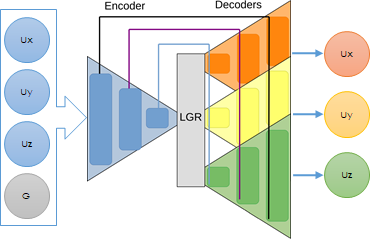

In [20]:
class UNetEx(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 filters=[16, 32, 64],
                 layers=3,
                 weight_norm=True,
                 batch_norm=True,
                 activation=nn.ReLU,
                 final_activation=None):
        
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels,
                                      filters,
                                      kernel_size,
                                      weight_norm,
                                      batch_norm,
                                      activation,
                                      layers)
        
        decoders = []
        for i in range(out_channels):
            decoders.append(create_decoder(1,
                                           filters,
                                           kernel_size,
                                           weight_norm,
                                           batch_norm,
                                           activation,
                                           layers))
            
        self.decoders = nn.Sequential(*decoders)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        
        return x, tensors, indices, sizes

    def decode(self, _x, _tensors, _indices, _sizes):
        
        y = []
        
        for _decoder in self.decoders:
            x = _x
            tensors = _tensors[:]
            indices = _indices[:]
            sizes = _sizes[:]
            for decoder in _decoder:
                tensor = tensors.pop()
                size = sizes.pop()
                ind = indices.pop()
                x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
                x = torch.cat([tensor, x], dim=1)
                x = decoder(x)
            y.append(x)
            
        return torch.cat(y, dim=1)

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        
        return x

In [21]:
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    
    mse_loss = nn.MSELoss()
    
    loss = 0
    
    for i in range(len(y[0])):
        loss += mse_loss(output[:,i,:,:], y[:,i,:,:])
        
    loss = (loss)/channels_weights
    
    return torch.sum(loss), output
    
#     if len(y[0]) > 1:
# #         # MSE written by authors of project
# #         lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
# #         lossz = ((output[:,2,:,:] - y[:,2,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
#         # changed to pyTorch function
#         lossu = mse_loss(output[:,0,:,:], y[:,0,:,:])
#         lossv = mse_loss(output[:,1,:,:], y[:,1,:,:])
#         lossz = mse_loss(output[:,2,:,:], y[:,2,:,:])
        
#     loss = (lossu + lossv + lossz)/channels_weights
    
#     else:
#         # MAE written by authors of project
#         loss = torch.abs((output[:,0,:,:] - y[:,0,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 

In [22]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_V.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_V.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [23]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [24]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [25]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [26]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_ux_curve = []
test_ux_curve = []

train_uy_curve = []
test_uy_curve = []

train_uz_curve = []
test_uz_curve = []

# train_p_curve = []
# test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    
    train_uz_curve.append(scope["train_metrics"]["uz"])
    test_uz_curve.append(scope["val_metrics"]["uz"])
    
#     train_p_curve.append(scope["train_metrics"]["p"])
#     test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [27]:
# Learning parameters

lr = 0.0001
kernel_size = 7
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNetEx(x_Nc,
               y_Nc,
               filters=filters,
               kernel_size=kernel_size,
               batch_norm=bn,
               weight_norm=wn,
               activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [28]:
mse_loss = nn.MSELoss()

model_v, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_ux_name="Ux MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_ux_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uy_name="Uy MSE",
#                                                                           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
                                                                          m_uy_on_batch=lambda scope: mse_loss(scope["output"][:,1,:,:], scope["batch"][1][:,1,:,:]).item(),
                                                                          m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uz_name="Uz MSE",
#                                                                           m_uz_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
                                                                          m_uz_on_batch=lambda scope: mse_loss(scope["output"][:,2,:,:], scope["batch"][1][:,2,:,:]).item(),
                                                                          m_uz_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve

curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve

curves["train_uz_curve"] = train_uz_curve
curves["test_uz_curve"] = test_uz_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelV.json", "w") as file:
    json.dump(config, file)

torch.save(model_v.state_dict(), simulation_directory + 'model_v.pth')

Epoch #1
	Train Loss = 1.5265093380585313
	Train Total MSE = 0.00012069175810026503
	Train Ux MSE = 0.00016872352475134312
	Train Uy MSE = 0.0001220045906387312
	Train Uz MSE = 7.134715617705929e-05
	Validation Loss = 0.23374542174860835
	Validation Total MSE = 4.3094658861513685e-05
	Validation Ux MSE = 4.2165905279437066e-05
	Validation Uy MSE = 5.712258808244745e-05
	Validation Uz MSE = 2.99954803251513e-05
Model saved!
Epoch #2
	Train Loss = 0.40361956413835287
	Train Total MSE = 3.1911730907673625e-05
	Train Ux MSE = 3.204905139494412e-05
	Train Uy MSE = 4.504956987613999e-05
	Train Uz MSE = 1.8636570181750623e-05
	Validation Loss = 0.13742219470441341
	Validation Total MSE = 2.5335951016461725e-05
	Validation Ux MSE = 2.607226434093694e-05
	Validation Uy MSE = 3.5888991891447686e-05
	Validation Uz MSE = 1.4046594692163367e-05
Model saved!
Epoch #3
	Train Loss = 0.24253518669866025
	Train Total MSE = 1.917577426683112e-05
	Train Ux MSE = 2.1648132528330375e-05
	Train Uy MSE = 2.41

	Validation Loss = 0.046455962932668626
	Validation Total MSE = 8.564890125113235e-06
	Validation Ux MSE = 1.2146070971981977e-05
	Validation Uy MSE = 6.9794600073040045e-06
	Validation Uz MSE = 6.569138880941679e-06
Model saved!
Epoch #21
	Train Loss = 0.10738546552602202
	Train Total MSE = 8.490312178716403e-06
	Train Ux MSE = 1.2125583335516914e-05
	Train Uy MSE = 7.204142787312184e-06
	Train Uz MSE = 6.141209729904737e-06
	Validation Loss = 0.052439949358813465
	Validation Total MSE = 9.668132632020942e-06
	Validation Ux MSE = 1.2220106609433527e-05
	Validation Uy MSE = 1.0005730835682779e-05
	Validation Uz MSE = 6.778559380479309e-06
Epoch #22
	Train Loss = 0.1075929932994768
	Train Total MSE = 8.506720167261317e-06
	Train Ux MSE = 1.2036808327382052e-05
	Train Uy MSE = 7.309629869317297e-06
	Train Uz MSE = 6.1737214007672894e-06
	Validation Loss = 0.04537879186682403
	Validation Total MSE = 8.366296838055183e-06
	Validation Ux MSE = 1.1911340562917243e-05
	Validation Uy MSE = 6.7

	Train Loss = 0.07743902830407023
	Train Total MSE = 6.122630510008249e-06
	Train Ux MSE = 8.485649615297345e-06
	Train Uy MSE = 4.910521713973277e-06
	Train Uz MSE = 4.9717196519508694e-06
	Validation Loss = 0.03334521927172318
	Validation Total MSE = 6.147717621251611e-06
	Validation Ux MSE = 8.461488899800605e-06
	Validation Uy MSE = 4.7066045612863275e-06
	Validation Uz MSE = 5.2750588553613545e-06
Model saved!
Epoch #41
	Train Loss = 0.0786670435918495
	Train Total MSE = 6.219722048147092e-06
	Train Ux MSE = 8.504831586843816e-06
	Train Uy MSE = 4.928708052868156e-06
	Train Uz MSE = 5.225626301085329e-06
	Validation Loss = 0.03671471227426082
	Validation Total MSE = 6.7689367414161616e-06
	Validation Ux MSE = 8.4083072836789e-06
	Validation Uy MSE = 6.386555614237328e-06
	Validation Uz MSE = 5.511946956095475e-06
Epoch #42
	Train Loss = 0.07981772616039962
	Train Total MSE = 6.3106995866770025e-06
	Train Ux MSE = 8.80844196610849e-06
	Train Uy MSE = 5.128268148112544e-06
	Train Uz

	Train Loss = 0.059994161303620785
	Train Total MSE = 4.743371564248556e-06
	Train Ux MSE = 6.7961780628630364e-06
	Train Uy MSE = 3.952736730029695e-06
	Train Uz MSE = 3.4811994235331292e-06
	Validation Loss = 0.029898678127210587
	Validation Total MSE = 5.5122933206529625e-06
	Validation Ux MSE = 7.096374875132357e-06
	Validation Uy MSE = 4.669980272064521e-06
	Validation Uz MSE = 4.770524291601341e-06
Epoch #61
	Train Loss = 0.06144295952981338
	Train Total MSE = 4.857919149826885e-06
	Train Ux MSE = 6.753596418340155e-06
	Train Uy MSE = 4.287344711364169e-06
	Train Uz MSE = 3.532815802037412e-06
	Validation Loss = 0.02755021321354434
	Validation Total MSE = 5.079316777852982e-06
	Validation Ux MSE = 7.004047898767285e-06
	Validation Uy MSE = 4.509891602208125e-06
	Validation Uz MSE = 3.7240103536903077e-06
Epoch #62
	Train Loss = 0.05907179100904614
	Train Total MSE = 4.670445386625639e-06
	Train Ux MSE = 6.5856991126776396e-06
	Train Uy MSE = 4.094309413948528e-06
	Train Uz MSE = 

	Validation Loss = 0.024390755512285978
	Validation Total MSE = 4.496820867514913e-06
	Validation Ux MSE = 6.257557151509465e-06
	Validation Uy MSE = 3.853652493183942e-06
	Validation Uz MSE = 3.3792523944475357e-06
Epoch #80
	Train Loss = 0.0556584766600281
	Train Total MSE = 4.4005754521621155e-06
	Train Ux MSE = 6.195270647232967e-06
	Train Uy MSE = 3.968741669180623e-06
	Train Uz MSE = 3.0377136189784355e-06
	Validation Loss = 0.023275336890947074
	Validation Total MSE = 4.291175785116477e-06
	Validation Ux MSE = 6.087668813068103e-06
	Validation Uy MSE = 3.799919803759219e-06
	Validation Uz MSE = 2.9859383360908233e-06
Epoch #81
	Train Loss = 0.051009841670747846
	Train Total MSE = 4.033036296828244e-06
	Train Ux MSE = 5.869039018908816e-06
	Train Uy MSE = 3.542574124480995e-06
	Train Uz MSE = 2.6874954847738665e-06
	Validation Loss = 0.022884610923938453
	Validation Total MSE = 4.219139273359803e-06
	Validation Ux MSE = 6.179292379791922e-06
	Validation Uy MSE = 3.738914682018360

	Train Loss = 0.04335259710205719
	Train Total MSE = 3.4276247735011995e-06
	Train Ux MSE = 5.1861927818683235e-06
	Train Uy MSE = 3.030676175055445e-06
	Train Uz MSE = 2.0660051771938188e-06
	Validation Loss = 0.019904136599507183
	Validation Total MSE = 3.6696417383263423e-06
	Validation Ux MSE = 5.304771813858131e-06
	Validation Uy MSE = 3.1887168843562886e-06
	Validation Uz MSE = 2.5154363638407187e-06
Epoch #100
	Train Loss = 0.04466329189017415
	Train Total MSE = 3.5312534385582564e-06
	Train Ux MSE = 5.218712708940844e-06
	Train Uy MSE = 3.1734575705297478e-06
	Train Uz MSE = 2.201589659980562e-06
	Validation Loss = 0.024348976323381066
	Validation Total MSE = 4.489118212010337e-06
	Validation Ux MSE = 6.2652109277102914e-06
	Validation Uy MSE = 4.615128614406093e-06
	Validation Uz MSE = 2.587014659288838e-06
Epoch #101
	Train Loss = 0.04636618436779827
	Train Total MSE = 3.6658906852017975e-06
	Train Ux MSE = 5.4259341286835074e-06
	Train Uy MSE = 3.2735225195245177e-06
	Train 

	Validation Loss = 0.019123434962239116
	Validation Total MSE = 3.5257070626397987e-06
	Validation Ux MSE = 4.870492770013078e-06
	Validation Uy MSE = 3.2988372150668462e-06
	Validation Uz MSE = 2.407791082110087e-06
Epoch #119
	Train Loss = 0.038437520270235837
	Train Total MSE = 3.0390197154988517e-06
	Train Ux MSE = 4.472338484431859e-06
	Train Uy MSE = 2.857110018255317e-06
	Train Uz MSE = 1.7876103849399197e-06
	Validation Loss = 0.017113824927946553
	Validation Total MSE = 3.1552037833422315e-06
	Validation Ux MSE = 4.567447976380241e-06
	Validation Uy MSE = 2.8740833615495277e-06
	Validation Uz MSE = 2.0240797625895306e-06
Epoch #120
	Train Loss = 0.036236329353414476
	Train Total MSE = 2.864984960105947e-06
	Train Ux MSE = 4.345123056262472e-06
	Train Uy MSE = 2.634114667564384e-06
	Train Uz MSE = 1.6157170046209022e-06
	Validation Loss = 0.01821227988693863
	Validation Total MSE = 3.3577213468714163e-06
	Validation Ux MSE = 5.461795116332772e-06
	Validation Uy MSE = 2.77015132

	Train Loss = 0.03380521005601622
	Train Total MSE = 2.6727712643073218e-06
	Train Ux MSE = 3.881534529815426e-06
	Train Uy MSE = 2.580498472435764e-06
	Train Uz MSE = 1.5562805231723341e-06
	Validation Loss = 0.021117019117809832
	Validation Total MSE = 3.893255876568846e-06
	Validation Ux MSE = 5.096094089789951e-06
	Validation Uy MSE = 3.0716834522230524e-06
	Validation Uz MSE = 3.51198962489756e-06
Epoch #139
	Train Loss = 0.04231372708454728
	Train Total MSE = 3.345487647729862e-06
	Train Ux MSE = 4.940537693406644e-06
	Train Uy MSE = 3.2733237353922045e-06
	Train Uz MSE = 1.822601324553134e-06
	Validation Loss = 0.020681788388174027
	Validation Total MSE = 3.813014145071548e-06
	Validation Ux MSE = 5.830578476760281e-06
	Validation Uy MSE = 3.594157243620365e-06
	Validation Uz MSE = 2.014306553861485e-06
Epoch #140
	Train Loss = 0.036249674536520615
	Train Total MSE = 2.866040136184865e-06
	Train Ux MSE = 4.253158707352155e-06
	Train Uy MSE = 2.6984477148914183e-06
	Train Uz MSE 

	Validation Loss = 0.01424237634637393
	Validation Total MSE = 2.625806922299336e-06
	Validation Ux MSE = 3.907810101752784e-06
	Validation Uy MSE = 2.4946469609021412e-06
	Validation Uz MSE = 1.4749634185168723e-06
Epoch #158
	Train Loss = 0.02865901729092002
	Train Total MSE = 2.265893254866267e-06
	Train Ux MSE = 3.170204471932164e-06
	Train Uy MSE = 2.360362115751159e-06
	Train Uz MSE = 1.2671130129648195e-06
	Validation Loss = 0.013890933973016217
	Validation Total MSE = 2.561012954287338e-06
	Validation Ux MSE = 3.67322398844923e-06
	Validation Uy MSE = 2.5108451017838453e-06
	Validation Uz MSE = 1.4989695633646714e-06
Epoch #159
	Train Loss = 0.028605910076294094
	Train Total MSE = 2.2616944215683475e-06
	Train Ux MSE = 3.2131542219235643e-06
	Train Uy MSE = 2.279994552574528e-06
	Train Uz MSE = 1.2919342744824002e-06
	Validation Loss = 0.012964406836545095
	Validation Total MSE = 2.390193108152969e-06
	Validation Ux MSE = 3.3881803324824173e-06
	Validation Uy MSE = 2.3378582235

	Train Loss = 0.03587482078000903
	Train Total MSE = 2.8364027101914108e-06
	Train Ux MSE = 4.351085220304303e-06
	Train Uy MSE = 2.746564609749553e-06
	Train Uz MSE = 1.4115581693598494e-06
	Validation Loss = 0.01588270437787287
	Validation Total MSE = 2.9282272431872726e-06
	Validation Ux MSE = 4.479539446005767e-06
	Validation Uy MSE = 2.8246445777059523e-06
	Validation Uz MSE = 1.4804975448775855e-06
Epoch #178
	Train Loss = 0.03254611245938577
	Train Total MSE = 2.573222097178852e-06
	Train Ux MSE = 3.8736385729420576e-06
	Train Uy MSE = 2.5577838180978355e-06
	Train Uz MSE = 1.2882437158364491e-06
	Validation Loss = 0.014607935649110004
	Validation Total MSE = 2.693203542202781e-06
	Validation Ux MSE = 3.838423189521145e-06
	Validation Uy MSE = 2.7604719676207173e-06
	Validation Uz MSE = 1.4807152561779006e-06
Epoch #179
	Train Loss = 0.04125362608465366
	Train Total MSE = 3.2616720296397446e-06
	Train Ux MSE = 4.811447553319611e-06
	Train Uy MSE = 3.366759280861153e-06
	Train Uz

	Validation Loss = 0.013029064110014588
	Validation Total MSE = 2.4021136620420904e-06
	Validation Ux MSE = 3.3767093748237477e-06
	Validation Uy MSE = 2.404642669008571e-06
	Validation Uz MSE = 1.4249887491269366e-06
Epoch #197
	Train Loss = 0.033109123760368675
	Train Total MSE = 2.6177360244614222e-06
	Train Ux MSE = 3.794498810354855e-06
	Train Uy MSE = 2.7180030659402003e-06
	Train Uz MSE = 1.340705899389333e-06
	Validation Loss = 0.013706002617254853
	Validation Total MSE = 2.5269180020256653e-06
	Validation Ux MSE = 3.6739968657787204e-06
	Validation Uy MSE = 2.5711406526604946e-06
	Validation Uz MSE = 1.3356161093523734e-06
Epoch #198
	Train Loss = 0.029069535055896267
	Train Total MSE = 2.2983504095464014e-06
	Train Ux MSE = 3.263887947037453e-06
	Train Uy MSE = 2.353901153405381e-06
	Train Uz MSE = 1.2772619495764432e-06
	Validation Loss = 0.0139457386394497
	Validation Total MSE = 2.571117094333131e-06
	Validation Ux MSE = 3.72604351299887e-06
	Validation Uy MSE = 2.57129182

	Train Loss = 0.022971733065787703
	Train Total MSE = 1.8162344681591447e-06
	Train Ux MSE = 2.5333400452037896e-06
	Train Uy MSE = 2.002673906353554e-06
	Train Uz MSE = 9.126893183079714e-07
	Validation Loss = 0.011139303358504549
	Validation Total MSE = 2.0537064156731473e-06
	Validation Ux MSE = 2.8179863239424737e-06
	Validation Uy MSE = 2.1968683186623338e-06
	Validation Uz MSE = 1.1462644736244667e-06
Model saved!
Epoch #217
	Train Loss = 0.022064157368731685
	Train Total MSE = 1.744478007722085e-06
	Train Ux MSE = 2.3885215179354307e-06
	Train Uy MSE = 1.9634898061351805e-06
	Train Uz MSE = 8.81422606765536e-07
	Validation Loss = 0.0106413027679082
	Validation Total MSE = 1.961892168958356e-06
	Validation Ux MSE = 2.6532726602389815e-06
	Validation Uy MSE = 2.1332431599985605e-06
	Validation Uz MSE = 1.0991605055434485e-06
Model saved!
Epoch #218
	Train Loss = 0.023675377160543576
	Train Total MSE = 1.8718673116043723e-06
	Train Ux MSE = 2.5601453892599464e-06
	Train Uy MSE = 2.

	Validation Loss = 0.010025930037954822
	Validation Total MSE = 1.8484384958983597e-06
	Validation Ux MSE = 2.505975695320743e-06
	Validation Uy MSE = 2.026693109092349e-06
	Validation Uz MSE = 1.0126465504796635e-06
Model saved!
Epoch #236
	Train Loss = 0.020748862792970613
	Train Total MSE = 1.6404857311703299e-06
	Train Ux MSE = 2.189534416433735e-06
	Train Uy MSE = 1.884079346342657e-06
	Train Uz MSE = 8.478432676468382e-07
	Validation Loss = 0.009962845593690872
	Validation Total MSE = 1.8368078937493388e-06
	Validation Ux MSE = 2.494184796742691e-06
	Validation Uy MSE = 2.0321984958229174e-06
	Validation Uz MSE = 9.84040163320889e-07
Model saved!
Epoch #237
	Train Loss = 0.02036790401325561
	Train Total MSE = 1.610365627537083e-06
	Train Ux MSE = 2.146489718301903e-06
	Train Uy MSE = 1.8674765473116362e-06
	Train Uz MSE = 8.171304815226925e-07
	Validation Loss = 0.009989915881305933
	Validation Total MSE = 1.841798717755128e-06
	Validation Ux MSE = 2.4957316741849547e-06
	Validat

	Train Loss = 0.019376049676793627
	Train Total MSE = 1.5319457688367533e-06
	Train Ux MSE = 2.050286999823984e-06
	Train Uy MSE = 1.8025607296053154e-06
	Train Uz MSE = 7.429894847508526e-07
	Validation Loss = 0.009800982777960598
	Validation Total MSE = 1.8069659157829212e-06
	Validation Ux MSE = 2.483470796231918e-06
	Validation Uy MSE = 1.984039876075998e-06
	Validation Uz MSE = 9.533868879102999e-07
Epoch #256
	Train Loss = 0.02002888373681344
	Train Total MSE = 1.5835613879906209e-06
	Train Ux MSE = 2.1375243613357033e-06
	Train Uy MSE = 1.8521755484308988e-06
	Train Uz MSE = 7.609840919803987e-07
	Validation Loss = 0.009931974433129653
	Validation Total MSE = 1.8311162759056438e-06
	Validation Ux MSE = 2.4668318361460654e-06
	Validation Uy MSE = 2.010650546132871e-06
	Validation Uz MSE = 1.0158663428180174e-06
Epoch #257
	Train Loss = 0.019515960171702318
	Train Total MSE = 1.5430076198157125e-06
	Train Ux MSE = 2.0654019613046045e-06
	Train Uy MSE = 1.819803998429497e-06
	Train

	Train Loss = 0.028899903205456212
	Train Total MSE = 2.2849386261762393e-06
	Train Ux MSE = 3.2799633055846066e-06
	Train Uy MSE = 2.4341716250024545e-06
	Train Uz MSE = 1.1406807917570832e-06
	Validation Loss = 0.011304939689580351
	Validation Total MSE = 2.0842440725758516e-06
	Validation Ux MSE = 2.897919314183023e-06
	Validation Uy MSE = 2.157767821458504e-06
	Validation Uz MSE = 1.1970449895268322e-06
Epoch #276
	Train Loss = 0.021727789644501172
	Train Total MSE = 1.7178834645185608e-06
	Train Ux MSE = 2.3241591614081683e-06
	Train Uy MSE = 1.959614616613177e-06
	Train Uz MSE = 8.698764843738106e-07
	Validation Loss = 0.009840630344115198
	Validation Total MSE = 1.8142755568955728e-06
	Validation Ux MSE = 2.5298546115181147e-06
	Validation Uy MSE = 1.9487486585917514e-06
	Validation Uz MSE = 9.642232818596231e-07
Epoch #277
	Train Loss = 0.019642617844510823
	Train Total MSE = 1.5530217001080979e-06
	Train Ux MSE = 2.095524375779228e-06
	Train Uy MSE = 1.808848836183865e-06
	Tra

	Validation Loss = 0.008831223531160504
	Validation Total MSE = 1.6281754955166715e-06
	Validation Ux MSE = 2.1769614636267546e-06
	Validation Uy MSE = 1.8832437856558379e-06
	Validation Uz MSE = 8.243210722705961e-07
Model saved!
Epoch #295
	Train Loss = 0.017827349627623335
	Train Total MSE = 1.4094995358684702e-06
	Train Ux MSE = 1.866515972488074e-06
	Train Uy MSE = 1.7227698283516198e-06
	Train Uz MSE = 6.392127049437294e-07
	Validation Loss = 0.009076089263544418
	Validation Total MSE = 1.6733203214630319e-06
	Validation Ux MSE = 2.2784751735368037e-06
	Validation Uy MSE = 1.8520347546542422e-06
	Validation Uz MSE = 8.894509194929779e-07
Epoch #296
	Train Loss = 0.0176320195896551
	Train Total MSE = 1.3940559723988825e-06
	Train Ux MSE = 1.8315332787300494e-06
	Train Uy MSE = 1.7084385820796897e-06
	Train Uz MSE = 6.421959826091127e-07
	Validation Loss = 0.009431652608327568
	Validation Total MSE = 1.7388740394960377e-06
	Validation Ux MSE = 2.399244532227337e-06
	Validation Uy M

	Train Loss = 0.017599112528841943
	Train Total MSE = 1.391454223877851e-06
	Train Ux MSE = 1.8233886294183321e-06
	Train Uy MSE = 1.6755524876080051e-06
	Train Uz MSE = 6.75421424741037e-07
	Validation Loss = 0.00877377635333687
	Validation Total MSE = 1.6175841802071298e-06
	Validation Ux MSE = 2.2003396949421748e-06
	Validation Uy MSE = 1.7835662348800652e-06
	Validation Uz MSE = 8.688464417780102e-07
Epoch #315
	Train Loss = 0.017112853762228042
	Train Total MSE = 1.3530087343164065e-06
	Train Ux MSE = 1.76997756935277e-06
	Train Uy MSE = 1.673248614133972e-06
	Train Uz MSE = 6.157998572376161e-07
	Validation Loss = 0.008639378662337549
	Validation Total MSE = 1.5928058502116484e-06
	Validation Ux MSE = 2.093128680834388e-06
	Validation Uy MSE = 1.8323656459604503e-06
	Validation Uz MSE = 8.529230890256266e-07
Epoch #316
	Train Loss = 0.01699911884497851
	Train Total MSE = 1.3440164005638107e-06
	Train Ux MSE = 1.7516131023826666e-06
	Train Uy MSE = 1.6550813323458187e-06
	Train Uz

	Validation Loss = 0.00795947173901368
	Validation Total MSE = 1.4674542841681309e-06
	Validation Ux MSE = 1.988422793420691e-06
	Validation Uy MSE = 1.7150270401237974e-06
	Validation Uz MSE = 6.989128992365971e-07
Epoch #334
	Train Loss = 0.01576076154015027
	Train Total MSE = 1.2461070377133682e-06
	Train Ux MSE = 1.6432777366636716e-06
	Train Uy MSE = 1.5823073328605878e-06
	Train Uz MSE = 5.127359737210909e-07
	Validation Loss = 0.008181434532161802
	Validation Total MSE = 1.5083765757215555e-06
	Validation Ux MSE = 2.0583542917630496e-06
	Validation Uy MSE = 1.7528980453660923e-06
	Validation Uz MSE = 7.138772874155475e-07
Epoch #335
	Train Loss = 0.01563156121119391
	Train Total MSE = 1.2358919841159387e-06
	Train Ux MSE = 1.6229018841930767e-06
	Train Uy MSE = 1.5758569211710887e-06
	Train Uz MSE = 5.089170201376158e-07
	Validation Loss = 0.007929025290650316
	Validation Total MSE = 1.4618409693915143e-06
	Validation Ux MSE = 1.9588379589839482e-06
	Validation Uy MSE = 1.735284

	Train Loss = 0.015768903351272456
	Train Total MSE = 1.2467507839309908e-06
	Train Ux MSE = 1.6439589749451438e-06
	Train Uy MSE = 1.5844674470632143e-06
	Train Uz MSE = 5.118257723056929e-07
	Validation Loss = 0.008074715718976222
	Validation Total MSE = 1.4887013078169624e-06
	Validation Ux MSE = 2.0519060145706078e-06
	Validation Uy MSE = 1.6700709977109821e-06
	Validation Uz MSE = 7.441268518106833e-07
Epoch #354
	Train Loss = 0.03512831348052714
	Train Total MSE = 2.7773809729961204e-06
	Train Ux MSE = 3.6123667114553e-06
	Train Uy MSE = 2.8611293126394566e-06
	Train Uz MSE = 1.8586467192938212e-06
	Validation Loss = 0.019663682323880494
	Validation Total MSE = 3.6253102622237014e-06
	Validation Ux MSE = 4.9790884576098115e-06
	Validation Uy MSE = 3.750521041706835e-06
	Validation Uz MSE = 2.1463210338227494e-06
Epoch #355
	Train Loss = 0.028569381349370815
	Train Total MSE = 2.258806323731562e-06
	Train Ux MSE = 3.1643090168243024e-06
	Train Uy MSE = 2.3387586464884514e-06
	Trai

	Validation Loss = 0.007407856130157597
	Validation Total MSE = 1.3657552466031876e-06
	Validation Ux MSE = 1.8477992156943651e-06
	Validation Uy MSE = 1.6277542143513601e-06
	Validation Uz MSE = 6.217121970830784e-07
Model saved!
Epoch #373
	Train Loss = 0.01486808191111777
	Train Total MSE = 1.1755283383991762e-06
	Train Ux MSE = 1.5549410350803102e-06
	Train Uy MSE = 1.5188895323147214e-06
	Train Uz MSE = 4.527543291539951e-07
	Validation Loss = 0.007509902352467179
	Validation Total MSE = 1.3845690358946547e-06
	Validation Ux MSE = 1.906692726160008e-06
	Validation Uy MSE = 1.6362525992458882e-06
	Validation Uz MSE = 6.107617601443471e-07
Epoch #374
	Train Loss = 0.015087073596077971
	Train Total MSE = 1.1928426798335206e-06
	Train Ux MSE = 1.5714968121997712e-06
	Train Uy MSE = 1.5332698265831822e-06
	Train Uz MSE = 4.7376127171432764e-07
	Validation Loss = 0.007652546002645977
	Validation Total MSE = 1.41086763658806e-06
	Validation Ux MSE = 1.885763848587032e-06
	Validation Uy M

	Train Loss = 0.015129659805097617
	Train Total MSE = 1.19620970774322e-06
	Train Ux MSE = 1.588571105709925e-06
	Train Uy MSE = 1.560078391838316e-06
	Train Uz MSE = 4.399795053071204e-07
	Validation Loss = 0.007329181331442669
	Validation Total MSE = 1.3512502930935038e-06
	Validation Ux MSE = 1.8519640293682409e-06
	Validation Uy MSE = 1.6030541914472701e-06
	Validation Uz MSE = 5.987325276748331e-07
Epoch #393
	Train Loss = 0.014448269022977911
	Train Total MSE = 1.1423363025081292e-06
	Train Ux MSE = 1.5082632404193966e-06
	Train Uy MSE = 1.4998982414235763e-06
	Train Uz MSE = 4.188473044442173e-07
	Validation Loss = 0.007345243764575571
	Validation Total MSE = 1.354211644061292e-06
	Validation Ux MSE = 1.8364382867730455e-06
	Validation Uy MSE = 1.6100711734633583e-06
	Validation Uz MSE = 6.161253160053495e-07
Epoch #394
	Train Loss = 0.014550459804013371
	Train Total MSE = 1.150415881529556e-06
	Train Ux MSE = 1.5221130360927733e-06
	Train Uy MSE = 1.5031913336268887e-06
	Train 

	Train Loss = 0.014546021455316804
	Train Total MSE = 1.1500649468722996e-06
	Train Ux MSE = 1.5129948900569632e-06
	Train Uy MSE = 1.5035616101472761e-06
	Train Uz MSE = 4.336383093483247e-07
	Validation Loss = 0.007316131072002463
	Validation Total MSE = 1.348844261078779e-06
	Validation Ux MSE = 1.845458580775442e-06
	Validation Uy MSE = 1.6084113848696728e-06
	Validation Uz MSE = 5.926626948496807e-07
Epoch #413
	Train Loss = 0.014802357931330334
	Train Total MSE = 1.1703319395576985e-06
	Train Ux MSE = 1.5507007999268013e-06
	Train Uy MSE = 1.5087612707439463e-06
	Train Uz MSE = 4.5153364618036027e-07
	Validation Loss = 0.007478279614588246
	Validation Total MSE = 1.3787388871179222e-06
	Validation Ux MSE = 1.8570065718304893e-06
	Validation Uy MSE = 1.612690737529514e-06
	Validation Uz MSE = 6.665192865986796e-07
Epoch #414
	Train Loss = 0.015339175384724513
	Train Total MSE = 1.2127748171067036e-06
	Train Ux MSE = 1.6021942577197348e-06
	Train Uy MSE = 1.5398823708039908e-06
	Tr

	Validation Loss = 0.007005134844803251
	Validation Total MSE = 1.2915071938470196e-06
	Validation Ux MSE = 1.7710465171494917e-06
	Validation Uy MSE = 1.5656515608852152e-06
	Validation Uz MSE = 5.378233908255923e-07
Model saved!
Epoch #432
	Train Loss = 0.01438790894462727
	Train Total MSE = 1.137563986204239e-06
	Train Ux MSE = 1.5063611651369614e-06
	Train Uy MSE = 1.4974325633195492e-06
	Train Uz MSE = 4.0889816371304517e-07
	Validation Loss = 0.007249610862345435
	Validation Total MSE = 1.3365802320887889e-06
	Validation Ux MSE = 1.7616309249576334e-06
	Validation Uy MSE = 1.6840252370875693e-06
	Validation Uz MSE = 5.640844014188402e-07
Epoch #433
	Train Loss = 0.014252342138206586
	Train Total MSE = 1.1268455626682044e-06
	Train Ux MSE = 1.5041624383971738e-06
	Train Uy MSE = 1.4780000173537576e-06
	Train Uz MSE = 3.983741287058979e-07
	Validation Loss = 0.0070008663315093145
	Validation Total MSE = 1.290720255568467e-06
	Validation Ux MSE = 1.7572939873992907e-06
	Validation U

	Train Loss = 0.01404554619512055
	Train Total MSE = 1.1104954720037503e-06
	Train Ux MSE = 1.470550461016996e-06
	Train Uy MSE = 1.475045340017732e-06
	Train Uz MSE = 3.8589048640469163e-07
	Validation Loss = 0.006929244096681941
	Validation Total MSE = 1.277515533391414e-06
	Validation Ux MSE = 1.731427720646411e-06
	Validation Uy MSE = 1.5588006481749265e-06
	Validation Uz MSE = 5.423181035809721e-07
Epoch #452
	Train Loss = 0.013997159549035132
	Train Total MSE = 1.1066698162899634e-06
	Train Ux MSE = 1.4590242543157042e-06
	Train Uy MSE = 1.4848860502555619e-06
	Train Uz MSE = 3.7609908001270855e-07
	Validation Loss = 0.00717360942508094
	Validation Total MSE = 1.3225681401968963e-06
	Validation Ux MSE = 1.8377194026196881e-06
	Validation Uy MSE = 1.5856468612623074e-06
	Validation Uz MSE = 5.443380108273529e-07
Epoch #453
	Train Loss = 0.013852346208295785
	Train Total MSE = 1.0952203290046488e-06
	Train Ux MSE = 1.4430505995389821e-06
	Train Uy MSE = 1.4747077940889316e-06
	Trai

	Validation Loss = 0.006867933174362406
	Validation Total MSE = 1.266211914709245e-06
	Validation Ux MSE = 1.7257946283843438e-06
	Validation Uy MSE = 1.579128384962768e-06
	Validation Uz MSE = 4.937126030086898e-07
Epoch #471
	Train Loss = 0.013567120462539606
	Train Total MSE = 1.072669264633088e-06
	Train Ux MSE = 1.4093441969346816e-06
	Train Uy MSE = 1.4519727324243207e-06
	Train Uz MSE = 3.566907508534236e-07
	Validation Loss = 0.006871083482110407
	Validation Total MSE = 1.2667927216476785e-06
	Validation Ux MSE = 1.7664373549491073e-06
	Validation Uy MSE = 1.5306027408423205e-06
	Validation Uz MSE = 5.033379645194741e-07
Epoch #472
	Train Loss = 0.013620977799291722
	Train Total MSE = 1.0769274359885617e-06
	Train Ux MSE = 1.4279343299046922e-06
	Train Uy MSE = 1.4470408056248325e-06
	Train Uz MSE = 3.5580706112229254e-07
	Validation Loss = 0.00693403348850552
	Validation Total MSE = 1.278398540066076e-06
	Validation Ux MSE = 1.732978256189046e-06
	Validation Uy MSE = 1.5616566

	Train Loss = 0.013430837825580966
	Train Total MSE = 1.061894233249401e-06
	Train Ux MSE = 1.4109294858931889e-06
	Train Uy MSE = 1.4371459942586182e-06
	Train Uz MSE = 3.3760714171983313e-07
	Validation Loss = 0.006727060972480103
	Validation Total MSE = 1.2402399031000327e-06
	Validation Ux MSE = 1.6758993003341993e-06
	Validation Uy MSE = 1.5626880498675102e-06
	Validation Uz MSE = 4.821322283082213e-07
Epoch #491
	Train Loss = 0.01359752631833544
	Train Total MSE = 1.0750732817576092e-06
	Train Ux MSE = 1.4364634012269735e-06
	Train Uy MSE = 1.4378864057840884e-06
	Train Uz MSE = 3.5086991529877184e-07
	Validation Loss = 0.007081862786435522
	Validation Total MSE = 1.3056532329796254e-06
	Validation Ux MSE = 1.7756916969497915e-06
	Validation Uy MSE = 1.6223622327566144e-06
	Validation Uz MSE = 5.189055831080011e-07
Epoch #492
	Train Loss = 0.013522181885491591
	Train Total MSE = 1.0691162355649957e-06
	Train Ux MSE = 1.4123883404188805e-06
	Train Uy MSE = 1.444684865736368e-06
	T

	Validation Loss = 0.006720729172229767
	Validation Total MSE = 1.2390725143342402e-06
	Validation Ux MSE = 1.7035038468844683e-06
	Validation Uy MSE = 1.5227339989286142e-06
	Validation Uz MSE = 4.909796247520073e-07
Epoch #510
	Train Loss = 0.013342262223886792
	Train Total MSE = 1.0548911041990908e-06
	Train Ux MSE = 1.3957512670713945e-06
	Train Uy MSE = 1.4378917730108864e-06
	Train Uz MSE = 3.310301780276386e-07
	Validation Loss = 0.0065360435110051185
	Validation Total MSE = 1.2050228054096676e-06
	Validation Ux MSE = 1.6450346941713024e-06
	Validation Uy MSE = 1.5158415110423786e-06
	Validation Uz MSE = 4.541920973284843e-07
Model saved!
Epoch #511
	Train Loss = 0.013220371489296667
	Train Total MSE = 1.0452539309368542e-06
	Train Ux MSE = 1.391531084809133e-06
	Train Uy MSE = 1.4196803119135659e-06
	Train Uz MSE = 3.2455032252579235e-07
	Validation Loss = 0.006672427014564164
	Validation Total MSE = 1.2301672734237747e-06
	Validation Ux MSE = 1.6879527309968185e-06
	Validation

	Train Loss = 0.013389443352934904
	Train Total MSE = 1.0586214148392746e-06
	Train Ux MSE = 1.4128600074776535e-06
	Train Uy MSE = 1.4254954318462719e-06
	Train Uz MSE = 3.3750871976697687e-07
	Validation Loss = 0.006633401797444094
	Validation Total MSE = 1.2229723493729314e-06
	Validation Ux MSE = 1.6709942404714937e-06
	Validation Uy MSE = 1.5270095144061626e-06
	Validation Uz MSE = 4.709131533962667e-07
Epoch #530
	Train Loss = 0.013396475813351572
	Train Total MSE = 1.0591774310599006e-06
	Train Ux MSE = 1.4058842909773298e-06
	Train Uy MSE = 1.4390035491713732e-06
	Train Uz MSE = 3.3264436415248403e-07
	Validation Loss = 0.007476713115465827
	Validation Total MSE = 1.3784500984042323e-06
	Validation Ux MSE = 1.8811836292445906e-06
	Validation Uy MSE = 1.6786459783578664e-06
	Validation Uz MSE = 5.755205849902622e-07
Epoch #531
	Train Loss = 0.01385158203629544
	Train Total MSE = 1.0951599080098548e-06
	Train Ux MSE = 1.4343604622275655e-06
	Train Uy MSE = 1.49588634811729e-06
	T

	Validation Loss = 0.006559249508427456
	Validation Total MSE = 1.2093011962587403e-06
	Validation Ux MSE = 1.654825648106815e-06
	Validation Uy MSE = 1.5256367865868417e-06
	Validation Uz MSE = 4.4744104190484364e-07
Epoch #549
	Train Loss = 0.01315874233841896
	Train Total MSE = 1.040381301854429e-06
	Train Ux MSE = 1.3906933590763694e-06
	Train Uy MSE = 1.4131866489619126e-06
	Train Uz MSE = 3.172638039005511e-07
	Validation Loss = 0.006575630293809809
	Validation Total MSE = 1.2123212629569379e-06
	Validation Ux MSE = 1.6537141288761761e-06
	Validation Uy MSE = 1.522459734966041e-06
	Validation Uz MSE = 4.607898374997925e-07
Epoch #550
	Train Loss = 0.01306264397862833
	Train Total MSE = 1.0327833857045127e-06
	Train Ux MSE = 1.3683293360869801e-06
	Train Uy MSE = 1.41569140945117e-06
	Train Uz MSE = 3.143293442693285e-07
	Validation Loss = 0.006541000788274687
	Validation Total MSE = 1.2059367449649722e-06
	Validation Ux MSE = 1.663077193724694e-06
	Validation Uy MSE = 1.509425039

	Train Loss = 0.012945367037900724
	Train Total MSE = 1.0235110242283692e-06
	Train Ux MSE = 1.3631909485970756e-06
	Train Uy MSE = 1.4100650172194411e-06
	Train Uz MSE = 2.9727702467753745e-07
	Validation Loss = 0.006686641070700716
	Validation Total MSE = 1.2327878435681403e-06
	Validation Ux MSE = 1.6869908598634369e-06
	Validation Uy MSE = 1.559375243586492e-06
	Validation Uz MSE = 4.519972954582463e-07
Epoch #569
	Train Loss = 0.012944484362378716
	Train Total MSE = 1.023441237336523e-06
	Train Ux MSE = 1.366551243312128e-06
	Train Uy MSE = 1.4025771322390261e-06
	Train Uz MSE = 3.011952387351938e-07
	Validation Loss = 0.006457506577135064
	Validation Total MSE = 1.1905432815328179e-06
	Validation Ux MSE = 1.6095461907865587e-06
	Validation Uy MSE = 1.5357140024706197e-06
	Validation Uz MSE = 4.263695467091413e-07
Epoch #570
	Train Loss = 0.012889957637526095
	Train Total MSE = 1.0191301353740718e-06
	Train Ux MSE = 1.3500125735809117e-06
	Train Uy MSE = 1.4117239584222773e-06
	Tr

	Validation Loss = 0.006548290315549821
	Validation Total MSE = 1.2072806984444502e-06
	Validation Ux MSE = 1.6626090273026436e-06
	Validation Uy MSE = 1.5485929404260473e-06
	Validation Uz MSE = 4.106400420880115e-07
Epoch #588
	Train Loss = 0.012969426141353324
	Train Total MSE = 1.0254132285140853e-06
	Train Ux MSE = 1.3678514729876891e-06
	Train Uy MSE = 1.4132671431260614e-06
	Train Uz MSE = 2.9512096825369185e-07
	Validation Loss = 0.006384678010363132
	Validation Total MSE = 1.1771161828707905e-06
	Validation Ux MSE = 1.6131461317886895e-06
	Validation Uy MSE = 1.485476940840988e-06
	Validation Uz MSE = 4.3272540555721913e-07
Epoch #589
	Train Loss = 0.012795963782991748
	Train Total MSE = 1.0116986174927118e-06
	Train Ux MSE = 1.3466853377902112e-06
	Train Uy MSE = 1.3972364002988392e-06
	Train Uz MSE = 2.9117403931694196e-07
	Validation Loss = 0.006486596037575509
	Validation Total MSE = 1.1959063786221566e-06
	Validation Ux MSE = 1.6288553428062468e-06
	Validation Uy MSE = 1.

	Train Loss = 0.012642838053579908
	Train Total MSE = 9.99591889987738e-07
	Train Ux MSE = 1.3317681512824604e-06
	Train Uy MSE = 1.3869140912596901e-06
	Train Uz MSE = 2.800933724113038e-07
	Validation Loss = 0.006473962217569351
	Validation Total MSE = 1.1935771657091508e-06
	Validation Ux MSE = 1.6194476503404928e-06
	Validation Uy MSE = 1.5213434046694021e-06
	Validation Uz MSE = 4.3994031032131143e-07
Epoch #608
	Train Loss = 0.012738040481053758
	Train Total MSE = 1.0071189820421732e-06
	Train Ux MSE = 1.3452840407316401e-06
	Train Uy MSE = 1.3893422684551612e-06
	Train Uz MSE = 2.867305355491797e-07
	Validation Loss = 0.006433340415242128
	Validation Total MSE = 1.186087853113301e-06
	Validation Ux MSE = 1.6128637014892862e-06
	Validation Uy MSE = 1.5196136000748534e-06
	Validation Uz MSE = 4.25786211496166e-07
Epoch #609
	Train Loss = 0.012692311473074369
	Train Total MSE = 1.0035034523946274e-06
	Train Ux MSE = 1.3319920655990236e-06
	Train Uy MSE = 1.3915626418591695e-06
	Tra

	Train Loss = 0.01266155644407263
	Train Total MSE = 1.0010718484146832e-06
	Train Ux MSE = 1.3271010477245283e-06
	Train Uy MSE = 1.3926761856666168e-06
	Train Uz MSE = 2.834382316033721e-07
	Validation Loss = 0.0064071420129039325
	Validation Total MSE = 1.1812577672048772e-06
	Validation Ux MSE = 1.6338712201716194e-06
	Validation Uy MSE = 1.495006363739752e-06
	Validation Uz MSE = 4.1489564727778565e-07
Epoch #628
	Train Loss = 0.01258286481606774
	Train Total MSE = 9.948501901748477e-07
	Train Ux MSE = 1.3240889660858124e-06
	Train Uy MSE = 1.388522862051163e-06
	Train Uz MSE = 2.7193864185992736e-07
	Validation Loss = 0.006233346604858525
	Validation Total MSE = 1.149215852345038e-06
	Validation Ux MSE = 1.57784469254983e-06
	Validation Uy MSE = 1.4766498249217576e-06
	Validation Uz MSE = 3.9315294700433124e-07
Model saved!
Epoch #629
	Train Loss = 0.012600294168805704
	Train Total MSE = 9.962282135746437e-07
	Train Ux MSE = 1.3206283452173028e-06
	Train Uy MSE = 1.39789642250229

	Validation Loss = 0.00644874811405316
	Validation Total MSE = 1.1889285078964793e-06
	Validation Ux MSE = 1.6352328283115253e-06
	Validation Uy MSE = 1.470914514610523e-06
	Validation Uz MSE = 4.6063810682064076e-07
Epoch #647
	Train Loss = 0.012731807837553788
	Train Total MSE = 1.0066261890782426e-06
	Train Ux MSE = 1.337578997496111e-06
	Train Uy MSE = 1.3964734645416797e-06
	Train Uz MSE = 2.8582603983239827e-07
	Validation Loss = 0.006315228791208938
	Validation Total MSE = 1.1643121172557455e-06
	Validation Ux MSE = 1.6083233469898352e-06
	Validation Uy MSE = 1.474222078217989e-06
	Validation Uz MSE = 4.103908978861837e-07
Epoch #648
	Train Loss = 0.012634034661459737
	Train Total MSE = 9.988958737117095e-07
	Train Ux MSE = 1.3405622022465965e-06
	Train Uy MSE = 1.3855639858525008e-06
	Train Uz MSE = 2.705613558066424e-07
	Validation Loss = 0.006485475736553781
	Validation Total MSE = 1.1956998207048767e-06
	Validation Ux MSE = 1.6723417936988068e-06
	Validation Uy MSE = 1.51088

	Train Loss = 0.01249728178663645
	Train Total MSE = 9.88083666084914e-07
	Train Ux MSE = 1.3137818360731578e-06
	Train Uy MSE = 1.389714835970267e-06
	Train Uz MSE = 2.607542427259161e-07
	Validation Loss = 0.006192070861288812
	Validation Total MSE = 1.1416060216404216e-06
	Validation Ux MSE = 1.5625008388342071e-06
	Validation Uy MSE = 1.4882476510548557e-06
	Validation Uz MSE = 3.740694844851629e-07
Epoch #667
	Train Loss = 0.012522907956736162
	Train Total MSE = 9.90109773491579e-07
	Train Ux MSE = 1.323182192964959e-06
	Train Uy MSE = 1.3841384331570043e-06
	Train Uz MSE = 2.6300859404085823e-07
	Validation Loss = 0.006244284435524605
	Validation Total MSE = 1.1512323892294156e-06
	Validation Ux MSE = 1.5838563076532869e-06
	Validation Uy MSE = 1.4966188455299284e-06
	Validation Uz MSE = 3.7322195313426107e-07
Epoch #668
	Train Loss = 0.0124827837353223
	Train Total MSE = 9.869374024721067e-07
	Train Ux MSE = 1.3215709411254396e-06
	Train Uy MSE = 1.3744449191141077e-06
	Train Uz

	Train Loss = 0.01305050177325029
	Train Total MSE = 1.0318233769421688e-06
	Train Ux MSE = 1.3836735217282315e-06
	Train Uy MSE = 1.4093875567062844e-06
	Train Uz MSE = 3.024089868117276e-07
	Validation Loss = 0.00640215852035908
	Validation Total MSE = 1.180338978352601e-06
	Validation Ux MSE = 1.6272222484857055e-06
	Validation Uy MSE = 1.4955822424040744e-06
	Validation Uz MSE = 4.182123903428391e-07
Epoch #687
	Train Loss = 0.012829189501644578
	Train Total MSE = 1.014325562641155e-06
	Train Ux MSE = 1.3589600521593258e-06
	Train Uy MSE = 1.3979442732275715e-06
	Train Uz MSE = 2.860723036437655e-07
	Validation Loss = 0.006259982503252104
	Validation Total MSE = 1.1541266086225684e-06
	Validation Ux MSE = 1.592000029857252e-06
	Validation Uy MSE = 1.4773842298205008e-06
	Validation Uz MSE = 3.929954514970366e-07
Epoch #688
	Train Loss = 0.01273842784576118
	Train Total MSE = 1.0071495968073763e-06
	Train Ux MSE = 1.348135682845313e-06
	Train Uy MSE = 1.3867871906461221e-06
	Train U

	Train Loss = 0.012404967317706905
	Train Total MSE = 9.807849409017492e-07
	Train Ux MSE = 1.305066651415718e-06
	Train Uy MSE = 1.3770692725478101e-06
	Train Uz MSE = 2.6021877146423533e-07
	Validation Loss = 0.00627133970556315
	Validation Total MSE = 1.156220511915211e-06
	Validation Ux MSE = 1.5877490516211653e-06
	Validation Uy MSE = 1.4752380678074e-06
	Validation Uz MSE = 4.0567423421691223e-07
Epoch #707
	Train Loss = 0.012440987629815936
	Train Total MSE = 9.836328242308671e-07
	Train Ux MSE = 1.321985657765975e-06
	Train Uy MSE = 1.3759444899227695e-06
	Train Uz MSE = 2.529682287907078e-07
	Validation Loss = 0.006136036150564905
	Validation Total MSE = 1.1312751075417984e-06
	Validation Ux MSE = 1.5843849474243795e-06
	Validation Uy MSE = 1.451894037114648e-06
	Validation Uz MSE = 3.575463018675522e-07
Model saved!
Epoch #708
	Train Loss = 0.012408188500558026
	Train Total MSE = 9.810396114988205e-07
	Train Ux MSE = 1.3149736650253644e-06
	Train Uy MSE = 1.3690898043867396e-

	Validation Loss = 0.006109597044996917
	Validation Total MSE = 1.126400663645099e-06
	Validation Ux MSE = 1.5501201772094969e-06
	Validation Uy MSE = 1.4559623019900691e-06
	Validation Uz MSE = 3.731194196795747e-07
Epoch #726
	Train Loss = 0.01237979259894928
	Train Total MSE = 9.78794510884021e-07
	Train Ux MSE = 1.3032548741153194e-06
	Train Uy MSE = 1.3823321559697265e-06
	Train Uz MSE = 2.5079640829538875e-07
	Validation Loss = 0.006204524906934239
	Validation Total MSE = 1.1439021134526784e-06
	Validation Ux MSE = 1.5918790791348546e-06
	Validation Uy MSE = 1.4698277725709991e-06
	Validation Uz MSE = 3.6999938804436055e-07
Epoch #727
	Train Loss = 0.012344219758233521
	Train Total MSE = 9.759819856715062e-07
	Train Ux MSE = 1.3111026821320808e-06
	Train Uy MSE = 1.367098306963939e-06
	Train Uz MSE = 2.497448850802718e-07
	Validation Loss = 0.006086676359700505
	Validation Total MSE = 1.1221748967228749e-06
	Validation Ux MSE = 1.548596566331916e-06
	Validation Uy MSE = 1.4457361

	Train Loss = 0.012153717725595925
	Train Total MSE = 9.609201493814072e-07
	Train Ux MSE = 1.2898652538539502e-06
	Train Uy MSE = 1.357607519635227e-06
	Train Uz MSE = 2.3528760001435015e-07
	Validation Loss = 0.006107167326263152
	Validation Total MSE = 1.1259527204011462e-06
	Validation Ux MSE = 1.5506002918163684e-06
	Validation Uy MSE = 1.4707415395838905e-06
	Validation Uz MSE = 3.565162367409454e-07
Epoch #746
	Train Loss = 0.012198799857287668
	Train Total MSE = 9.644845246979185e-07
	Train Ux MSE = 1.2880586548056443e-06
	Train Uy MSE = 1.3665423912709532e-06
	Train Uz MSE = 2.3885243007821224e-07
	Validation Loss = 0.006199813236889895
	Validation Total MSE = 1.1430334031493794e-06
	Validation Ux MSE = 1.596769409006489e-06
	Validation Uy MSE = 1.4681045069817758e-06
	Validation Uz MSE = 3.64226298993304e-07
Epoch #747
	Train Loss = 0.012283261377888266
	Train Total MSE = 9.711623790947166e-07
	Train Ux MSE = 1.2903186002896106e-06
	Train Uy MSE = 1.374012008696495e-06
	Train

	Train Loss = 0.012139110651332885
	Train Total MSE = 9.597652611011008e-07
	Train Ux MSE = 1.2967822566035665e-06
	Train Uy MSE = 1.3507374909063203e-06
	Train Uz MSE = 2.317759635256915e-07
	Validation Loss = 0.006072949181543663
	Validation Total MSE = 1.1196440516515048e-06
	Validation Ux MSE = 1.5514497498070422e-06
	Validation Uy MSE = 1.4572267234779352e-06
	Validation Uz MSE = 3.502556102379844e-07
Epoch #766
	Train Loss = 0.012140136612288188
	Train Total MSE = 9.598463743947074e-07
	Train Ux MSE = 1.2870850972472283e-06
	Train Uy MSE = 1.3579509889287145e-06
	Train Uz MSE = 2.3450296991784446e-07
	Validation Loss = 0.006110982889367733
	Validation Total MSE = 1.1266562024800291e-06
	Validation Ux MSE = 1.5488077059293637e-06
	Validation Uy MSE = 1.468814413373068e-06
	Validation Uz MSE = 3.6234633420768914e-07
Epoch #767
	Train Loss = 0.01217421635374194
	Train Total MSE = 9.625408430530206e-07
	Train Ux MSE = 1.3074000058067208e-06
	Train Uy MSE = 1.3469736191350326e-06
	Tra

	Validation Loss = 0.006181647535413504
	Validation Total MSE = 1.1396842794571396e-06
	Validation Ux MSE = 1.5579684504620222e-06
	Validation Uy MSE = 1.4813282535947391e-06
	Validation Uz MSE = 3.7975611519917127e-07
Epoch #785
	Train Loss = 0.012417055397236254
	Train Total MSE = 9.81740635173098e-07
	Train Ux MSE = 1.3304874011022931e-06
	Train Uy MSE = 1.367424531668368e-06
	Train Uz MSE = 2.473099209747407e-07
	Validation Loss = 0.006218867514689919
	Validation Total MSE = 1.1465464149698599e-06
	Validation Ux MSE = 1.5869303776115586e-06
	Validation Uy MSE = 1.4930661217903459e-06
	Validation Uz MSE = 3.5964260163849097e-07
Epoch #786
	Train Loss = 0.012370676311547868
	Train Total MSE = 9.78073732449824e-07
	Train Ux MSE = 1.310931608249633e-06
	Train Uy MSE = 1.3760535576664318e-06
	Train Uz MSE = 2.472359746978507e-07
	Validation Loss = 0.006172995374072343
	Validation Total MSE = 1.138089146479615e-06
	Validation Ux MSE = 1.551479123266459e-06
	Validation Uy MSE = 1.46140765

	Train Loss = 0.017575452977325767
	Train Total MSE = 1.3895835943315846e-06
	Train Ux MSE = 1.8746475350857047e-06
	Train Uy MSE = 1.6772059179114932e-06
	Train Uz MSE = 6.16897231195712e-07
	Validation Loss = 0.007217554724775255
	Validation Total MSE = 1.3306701302767135e-06
	Validation Ux MSE = 1.8287277617247103e-06
	Validation Uy MSE = 1.5930279047515957e-06
	Validation Uz MSE = 5.702546901471755e-07
Epoch #805
	Train Loss = 0.013326933323696721
	Train Total MSE = 1.0536791429690026e-06
	Train Ux MSE = 1.4014928924544176e-06
	Train Uy MSE = 1.4125848814473252e-06
	Train Uz MSE = 3.469595676368224e-07
	Validation Loss = 0.006282564936554991
	Validation Total MSE = 1.1582900429632184e-06
	Validation Ux MSE = 1.5754311853740056e-06
	Validation Uy MSE = 1.4745788466302454e-06
	Validation Uz MSE = 4.248599887319966e-07
Epoch #806
	Train Loss = 0.012500711192842573
	Train Total MSE = 9.883547956022334e-07
	Train Ux MSE = 1.3192629904574158e-06
	Train Uy MSE = 1.3816160307140678e-06
	Tr

	Validation Loss = 0.006190470652654767
	Validation Total MSE = 1.1413110032904558e-06
	Validation Ux MSE = 1.600442390280582e-06
	Validation Uy MSE = 1.45865965401126e-06
	Validation Uz MSE = 3.648308393167099e-07
Epoch #824
	Train Loss = 0.01227396273316117
	Train Total MSE = 9.70427202341171e-07
	Train Ux MSE = 1.3140173184029772e-06
	Train Uy MSE = 1.3605513896027591e-06
	Train Uz MSE = 2.367127872724594e-07
	Validation Loss = 0.006157443975098431
	Validation Total MSE = 1.1352219996450133e-06
	Validation Ux MSE = 1.5733717875457286e-06
	Validation Uy MSE = 1.4605981665122232e-06
	Validation Uz MSE = 3.7169594477230593e-07
Epoch #825
	Train Loss = 0.012169326102593914
	Train Total MSE = 9.621542094343724e-07
	Train Ux MSE = 1.2994826326629504e-06
	Train Uy MSE = 1.3535584785614727e-06
	Train Uz MSE = 2.334214452424192e-07
	Validation Loss = 0.00619379612908233
	Validation Total MSE = 1.1419241143941319e-06
	Validation Ux MSE = 1.555705683984391e-06
	Validation Uy MSE = 1.4899859514

	Train Loss = 0.012948376213898882
	Train Total MSE = 1.0237489399311099e-06
	Train Ux MSE = 1.386503527532462e-06
	Train Uy MSE = 1.4093694505133741e-06
	Train Uz MSE = 2.7537374898593714e-07
	Validation Loss = 0.0061504576515289955
	Validation Total MSE = 1.1339339670106774e-06
	Validation Ux MSE = 1.5659588302495432e-06
	Validation Uy MSE = 1.4557541393780444e-06
	Validation Uz MSE = 3.800888282814284e-07
Epoch #844
	Train Loss = 0.01274674363230588
	Train Total MSE = 1.0078070751869383e-06
	Train Ux MSE = 1.3629877386598996e-06
	Train Uy MSE = 1.3966710686607058e-06
	Train Uz MSE = 2.637623610732039e-07
	Validation Loss = 0.00612534859101288
	Validation Total MSE = 1.129304705379815e-06
	Validation Ux MSE = 1.5552911656768066e-06
	Validation Uy MSE = 1.4643620001699465e-06
	Validation Uz MSE = 3.682608577334971e-07
Epoch #845
	Train Loss = 0.012845037592342123
	Train Total MSE = 1.0155785779788581e-06
	Train Ux MSE = 1.370139784955601e-06
	Train Uy MSE = 1.4084806377556354e-06
	Tra

	Train Loss = 0.012469683126255404
	Train Total MSE = 9.859015980263078e-07
	Train Ux MSE = 1.3251748924049508e-06
	Train Uy MSE = 1.3745595775752016e-06
	Train Uz MSE = 2.579702406133702e-07
	Validation Loss = 0.005997774642310105
	Validation Total MSE = 1.1057844460034997e-06
	Validation Ux MSE = 1.5346466339761453e-06
	Validation Uy MSE = 1.438640315910537e-06
	Validation Uz MSE = 3.440662764491353e-07
Epoch #864
	Train Loss = 0.012437173754733521
	Train Total MSE = 9.833312831608705e-07
	Train Ux MSE = 1.328202721935799e-06
	Train Uy MSE = 1.3736149905294706e-06
	Train Uz MSE = 2.4817605827788084e-07
	Validation Loss = 0.006135252653621137
	Validation Total MSE = 1.1311306870269199e-06
	Validation Ux MSE = 1.5840986396995552e-06
	Validation Uy MSE = 1.4648523989082798e-06
	Validation Uz MSE = 3.444409027496179e-07
Epoch #865
	Train Loss = 0.012613707694981713
	Train Total MSE = 9.972887456626831e-07
	Train Ux MSE = 1.3337944731193279e-06
	Train Uy MSE = 1.4044377547548785e-06
	Trai

	Validation Loss = 0.00607144960667938
	Validation Total MSE = 1.119367575322948e-06
	Validation Ux MSE = 1.546924898972806e-06
	Validation Uy MSE = 1.4566506239794457e-06
	Validation Uz MSE = 3.5452711850602284e-07
Epoch #883
	Train Loss = 0.012376708051306196
	Train Total MSE = 9.785506265144375e-07
	Train Ux MSE = 1.3161799151637222e-06
	Train Uy MSE = 1.3739521442710395e-06
	Train Uz MSE = 2.455197454678567e-07
	Validation Loss = 0.006041872184141539
	Validation Total MSE = 1.1139145267930164e-06
	Validation Ux MSE = 1.5529855503282146e-06
	Validation Uy MSE = 1.4543974494514679e-06
	Validation Uz MSE = 3.3436046087605967e-07
Epoch #884
	Train Loss = 0.012410508752509486
	Train Total MSE = 9.81223036906089e-07
	Train Ux MSE = 1.3377516837038438e-06
	Train Uy MSE = 1.3655870861666923e-06
	Train Uz MSE = 2.4033026577558777e-07
	Validation Loss = 0.006156445189844817
	Validation Total MSE = 1.1350378621806415e-06
	Validation Ux MSE = 1.6023907895121143e-06
	Validation Uy MSE = 1.45225

	Train Loss = 0.012118569553422276
	Train Total MSE = 9.581411848685472e-07
	Train Ux MSE = 1.2912943409804701e-06
	Train Uy MSE = 1.3582822857487574e-06
	Train Uz MSE = 2.2484683489913342e-07
	Validation Loss = 0.0059544743198785
	Validation Total MSE = 1.0978013542465314e-06
	Validation Ux MSE = 1.5192942004255482e-06
	Validation Uy MSE = 1.4413184669290915e-06
	Validation Uz MSE = 3.327912746555691e-07
Epoch #903
	Train Loss = 0.012431603208824527
	Train Total MSE = 9.82890856468495e-07
	Train Ux MSE = 1.320090131449421e-06
	Train Uy MSE = 1.374677509009164e-06
	Train Uz MSE = 2.5390484222563063e-07
	Validation Loss = 0.006037545332219452
	Validation Total MSE = 1.1131167842405674e-06
	Validation Ux MSE = 1.5549868954316223e-06
	Validation Uy MSE = 1.4436107738751225e-06
	Validation Uz MSE = 3.407525999104657e-07
Epoch #904
	Train Loss = 0.012305213967920281
	Train Total MSE = 9.728980302216498e-07
	Train Ux MSE = 1.3058344163826482e-06
	Train Uy MSE = 1.3839520480089128e-06
	Train 

	Validation Loss = 0.005970453858026303
	Validation Total MSE = 1.1007474269106237e-06
	Validation Ux MSE = 1.5166818600009396e-06
	Validation Uy MSE = 1.4424792367063408e-06
	Validation Uz MSE = 3.4308105725873584e-07
Epoch #922
	Train Loss = 0.012125142144213896
	Train Total MSE = 9.58660833381677e-07
	Train Ux MSE = 1.2890097079790295e-06
	Train Uy MSE = 1.3550628086851511e-06
	Train Uz MSE = 2.3190993882586861e-07
	Validation Loss = 0.006079436192521825
	Validation Total MSE = 1.1208400562998223e-06
	Validation Ux MSE = 1.5355268055224117e-06
	Validation Uy MSE = 1.4501491745475312e-06
	Validation Uz MSE = 3.768440721244515e-07
Epoch #923
	Train Loss = 0.012119962644646876
	Train Total MSE = 9.58251347630024e-07
	Train Ux MSE = 1.2917813365628506e-06
	Train Uy MSE = 1.3587994611956488e-06
	Train Uz MSE = 2.2417315107566924e-07
	Validation Loss = 0.005975513631710783
	Validation Total MSE = 1.1016802676572578e-06
	Validation Ux MSE = 1.5247691593267358e-06
	Validation Uy MSE = 1.443

	Train Loss = 0.012061505047313403
	Train Total MSE = 9.536294603691701e-07
	Train Ux MSE = 1.2926888060425503e-06
	Train Uy MSE = 1.3540846816493224e-06
	Train Uz MSE = 2.1411481532335049e-07
	Validation Loss = 0.005923662261920981
	Validation Total MSE = 1.0921206171386767e-06
	Validation Ux MSE = 1.5125800227986924e-06
	Validation Uy MSE = 1.441472598110852e-06
	Validation Uz MSE = 3.2230922698521184e-07
Epoch #942
	Train Loss = 0.012026523392705712
	Train Total MSE = 9.508636550538452e-07
	Train Ux MSE = 1.2861605639556427e-06
	Train Uy MSE = 1.345884479383001e-06
	Train Uz MSE = 2.2054588450254478e-07
	Validation Loss = 0.006099444326537196
	Validation Total MSE = 1.1245288591598448e-06
	Validation Ux MSE = 1.580395038435143e-06
	Validation Uy MSE = 1.443962802652932e-06
	Validation Uz MSE = 3.4922863377148203e-07
Epoch #943
	Train Loss = 0.012223420984810218
	Train Total MSE = 9.664311669465372e-07
	Train Ux MSE = 1.3084955594810657e-06
	Train Uy MSE = 1.3633170206126478e-06
	Tra

	Validation Loss = 0.006053143908502534
	Validation Total MSE = 1.1159926467307016e-06
	Validation Ux MSE = 1.5688725474384043e-06
	Validation Uy MSE = 1.4627770597707666e-06
	Validation Uz MSE = 3.1632827161216337e-07
Epoch #961
	Train Loss = 0.011988538775767665
	Train Total MSE = 9.478604595407829e-07
	Train Ux MSE = 1.292379185656716e-06
	Train Uy MSE = 1.3429233225443987e-06
	Train Uz MSE = 2.0827879556481502e-07
	Validation Loss = 0.0058869982094620354
	Validation Total MSE = 1.0853610482812236e-06
	Validation Ux MSE = 1.5074614389331813e-06
	Validation Uy MSE = 1.4228631538676421e-06
	Validation Uz MSE = 3.25758492181194e-07
Epoch #962
	Train Loss = 0.011855172939249314
	Train Total MSE = 9.37316018285576e-07
	Train Ux MSE = 1.2629271839742084e-06
	Train Uy MSE = 1.3419268097366433e-06
	Train Uz MSE = 2.0709402037393625e-07
	Validation Loss = 0.005913366097956896
	Validation Total MSE = 1.0902223870031607e-06
	Validation Ux MSE = 1.5225735606425554e-06
	Validation Uy MSE = 1.433

	Train Loss = 0.011953908047871664
	Train Total MSE = 9.451224171121135e-07
	Train Ux MSE = 1.273365327388972e-06
	Train Uy MSE = 1.3504833427941086e-06
	Train Uz MSE = 2.1151852247618232e-07
	Validation Loss = 0.005883177145733498
	Validation Total MSE = 1.0846566124401979e-06
	Validation Ux MSE = 1.5155692662787726e-06
	Validation Uy MSE = 1.4197419999521848e-06
	Validation Uz MSE = 3.186584045836922e-07
Epoch #981
	Train Loss = 0.011933581306948327
	Train Total MSE = 9.435152959662726e-07
	Train Ux MSE = 1.2764957007216486e-06
	Train Uy MSE = 1.3450200456566303e-06
	Train Uz MSE = 2.0903009535548516e-07
	Validation Loss = 0.005881425240659155
	Validation Total MSE = 1.0843335798424766e-06
	Validation Ux MSE = 1.499392967355006e-06
	Validation Uy MSE = 1.4321144640516408e-06
	Validation Uz MSE = 3.2149324171962136e-07
Epoch #982
	Train Loss = 0.01189375331159681
	Train Total MSE = 9.403663569473948e-07
	Train Ux MSE = 1.2680216102524656e-06
	Train Uy MSE = 1.344271214401983e-06
	Trai

	Train Loss = 0.014108841576671693
	Train Total MSE = 1.1154998432058135e-06
	Train Ux MSE = 1.4834095779373408e-06
	Train Uy MSE = 1.4699346174755372e-06
	Train Uz MSE = 3.9315524597322176e-07
	Validation Loss = 0.006310967626632191
	Validation Total MSE = 1.1635265039821955e-06
	Validation Ux MSE = 1.5994731808127372e-06
	Validation Uy MSE = 1.496228793032253e-06
	Validation Uz MSE = 3.94877460633574e-07


In [29]:
# test prediction
out = model_v(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

Sampled model number: 5


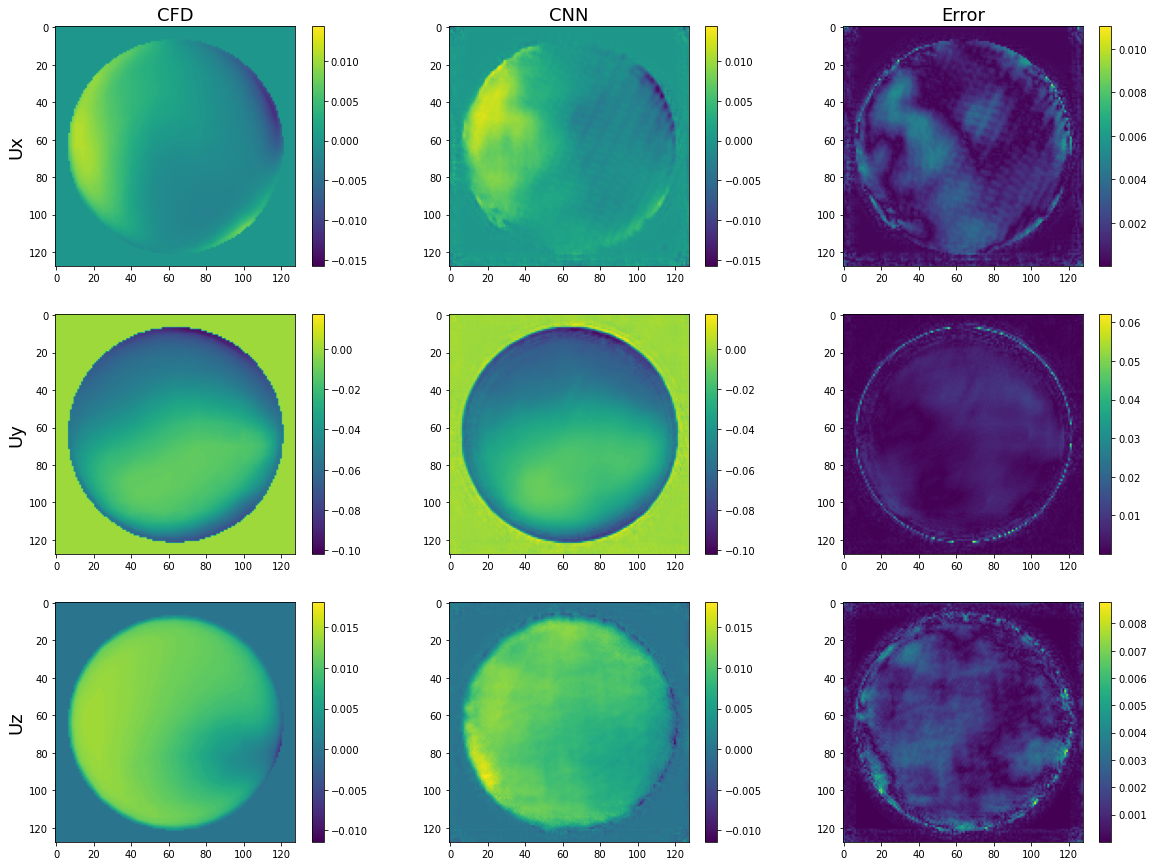

In [30]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

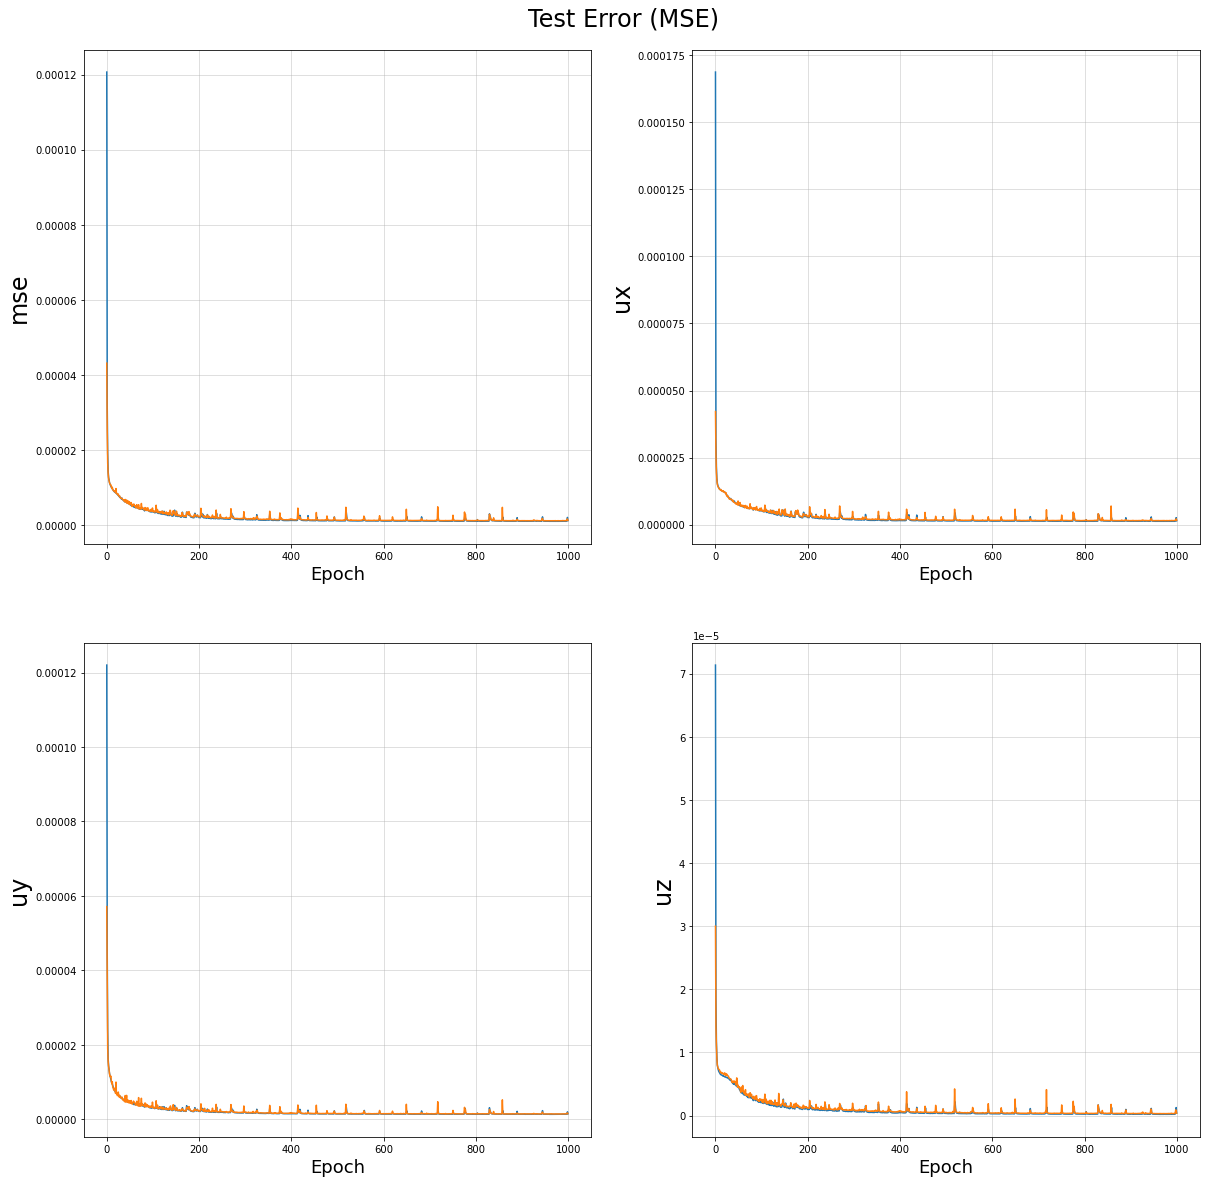

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Test Error (MSE)', y=0.91, fontsize=24)

curve2plot = list(curves.keys())[2:]

for i in range(4):
    axs[i//2][i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i//2][i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i//2][i%2].grid(alpha=0.5)
#     axs[i//2][i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelV.png')

## Model P

##### "Pressure+Velocity to Pressure"

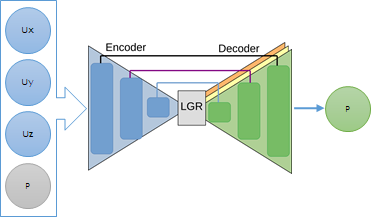

In [32]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, filters=[16, 32, 64], layers=2,
                 weight_norm=True, batch_norm=True, activation=nn.ReLU, final_activation=None):
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)
        self.decoder = create_decoder(out_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        return x, tensors, indices, sizes

    def decode(self, x, tensors, indices, sizes):
        for decoder in self.decoder:
            tensor = tensors.pop()
            size = sizes.pop()
            ind = indices.pop()
            x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
            x = torch.cat([tensor, x], dim=1)
            x = decoder(x)
        return x

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

In [33]:
# def loss_func(model, batch):
#     x, y = batch
#     output = model(x)
    
#     mae_loss = nn.L1Loss()
    
#     loss = 0
    
#     for i in range(len(y[0])):
#         loss += mae_loss(output[:,i,:,:], y[:,i,:,:])
        
#     loss = (loss)/channels_weights
    
#     return torch.sum(loss), output

In [34]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_P.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_P.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [35]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

# channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
#                                          .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)

# print(channels_weights)

channels_weights = 1

In [36]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [37]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [38]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics" ]["p"])

### Training model

In [39]:
# Learning parameters

lr = 0.0001
kernel_size = 7
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005

model = UNet(x_Nc,
             y_Nc,
             filters=filters,
             kernel_size=kernel_size,
             batch_norm=bn,
             weight_norm=wn,
             activation=nn.ReLU)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [40]:
mse_loss = nn.MSELoss()

model_p, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
#                                                                           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_batch=lambda scope: mse_loss(scope["output"], scope["batch"][1]).item(),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_p_name="P MSE",
#                                                                           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_p_on_batch=lambda scope: mse_loss(scope["output"][:,0,:,:], scope["batch"][1][:,0,:,:]).item(),
                                                                          m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results_ModelP.json", "w") as file:
    json.dump(config, file)

torch.save(model_p.state_dict(), simulation_directory + 'model_p.pth')

Epoch #1
	Train Loss = 0.6481705377809703
	Train Total MSE = 0.000153740639891122
	Train P MSE = 0.000153740639891122
	Validation Loss = 0.17623025923967361
	Validation Total MSE = 9.74724885175186e-05
	Validation P MSE = 9.74724885175186e-05
Model saved!
Epoch #2
	Train Loss = 0.3694612714461982
	Train Total MSE = 8.76331289009009e-05
	Train P MSE = 8.76331289009009e-05
	Validation Loss = 0.13956011086702347
	Validation Total MSE = 7.7190326806982e-05
	Validation P MSE = 7.7190326806982e-05
Model saved!
Epoch #3
	Train Loss = 0.30375018739141524
	Train Total MSE = 7.204700839454821e-05
	Train P MSE = 7.204700839454821e-05
	Validation Loss = 0.11665578349493444
	Validation Total MSE = 6.452200414542833e-05
	Validation P MSE = 6.452200414542833e-05
Model saved!
Epoch #4
	Train Loss = 0.26728001656010747
	Train Total MSE = 6.339658836814693e-05
	Train P MSE = 6.339658836814693e-05
	Validation Loss = 0.10860045743174851
	Validation Total MSE = 6.006662468570161e-05
	Validation P MSE = 6.0

	Train Loss = 0.11776924994774163
	Train Total MSE = 2.7933882814929227e-05
	Train P MSE = 2.7933882814929227e-05
	Validation Loss = 0.052952164434827864
	Validation Total MSE = 2.9287701567935764e-05
	Validation P MSE = 2.9287701567935764e-05
Epoch #34
	Train Loss = 0.11487822642084211
	Train Total MSE = 2.7248156171926496e-05
	Train P MSE = 2.7248156171926496e-05
	Validation Loss = 0.052628108533099294
	Validation Total MSE = 2.9108467109015096e-05
	Validation P MSE = 2.9108467109015096e-05
Epoch #35
	Train Loss = 0.11343843070790172
	Train Total MSE = 2.6906648649881813e-05
	Train P MSE = 2.6906648649881813e-05
	Validation Loss = 0.04874104342889041
	Validation Total MSE = 2.695854171951903e-05
	Validation P MSE = 2.695854171951903e-05
Model saved!
Epoch #36
	Train Loss = 0.11401855666190386
	Train Total MSE = 2.7044249682614767e-05
	Train P MSE = 2.7044249682614767e-05
	Validation Loss = 0.05492200097069144
	Validation Total MSE = 3.037721292626739e-05
	Validation P MSE = 3.0377212

	Train Loss = 0.09038365341257304
	Train Total MSE = 2.143824796313402e-05
	Train P MSE = 2.143824796313402e-05
	Validation Loss = 0.04079719027504325
	Validation Total MSE = 2.2564817630001796e-05
	Validation P MSE = 2.2564817630001796e-05
Model saved!
Epoch #66
	Train Loss = 0.09071639447938651
	Train Total MSE = 2.1517171366078392e-05
	Train P MSE = 2.1517171366078392e-05
	Validation Loss = 0.041817659861408174
	Validation Total MSE = 2.3129236649008947e-05
	Validation P MSE = 2.3129236649008947e-05
Epoch #67
	Train Loss = 0.0899600979173556
	Train Total MSE = 2.1337784135995162e-05
	Train P MSE = 2.1337784135995162e-05
	Validation Loss = 0.04116864514071494
	Validation Total MSE = 2.277026833004145e-05
	Validation P MSE = 2.277026833004145e-05
Epoch #68
	Train Loss = 0.08660991728538647
	Train Total MSE = 2.0543149261239676e-05
	Train P MSE = 2.0543149261239676e-05
	Validation Loss = 0.0415105486754328
	Validation Total MSE = 2.29593742673854e-05
	Validation P MSE = 2.2959374267385

	Validation Loss = 0.03878413187339902
	Validation Total MSE = 2.145140037245521e-05
	Validation P MSE = 2.145140037245521e-05
Epoch #98
	Train Loss = 0.07654461555648595
	Train Total MSE = 1.8155743727819247e-05
	Train P MSE = 1.8155743727819247e-05
	Validation Loss = 0.03648325050016865
	Validation Total MSE = 2.0178788993456112e-05
	Validation P MSE = 2.0178788993456112e-05
Model saved!
Epoch #99
	Train Loss = 0.07340391125762835
	Train Total MSE = 1.7410794890329307e-05
	Train P MSE = 1.7410794890329307e-05
	Validation Loss = 0.036497888853773475
	Validation Total MSE = 2.0186885427972054e-05
	Validation P MSE = 2.0186885427972054e-05
Epoch #100
	Train Loss = 0.07326871779514477
	Train Total MSE = 1.737872812977817e-05
	Train P MSE = 1.737872812977817e-05
	Validation Loss = 0.03699436888564378
	Validation Total MSE = 2.046148721551094e-05
	Validation P MSE = 2.046148721551094e-05
Epoch #101
	Train Loss = 0.07183155999518931
	Train Total MSE = 1.703784629866919e-05
	Train P MSE = 1.

	Validation Loss = 0.03288469888502732
	Validation Total MSE = 1.8188439648798296e-05
	Validation P MSE = 1.8188439648798296e-05
Epoch #130
	Train Loss = 0.061423397273756564
	Train Total MSE = 1.4569117000416643e-05
	Train P MSE = 1.4569117000416643e-05
	Validation Loss = 0.03297898720484227
	Validation Total MSE = 1.8240590268164972e-05
	Validation P MSE = 1.8240590268164972e-05
Epoch #131
	Train Loss = 0.0631794331711717
	Train Total MSE = 1.4985634053883229e-05
	Train P MSE = 1.4985634053883229e-05
	Validation Loss = 0.03477561456384137
	Validation Total MSE = 1.923430009062023e-05
	Validation P MSE = 1.923430009062023e-05
Epoch #132
	Train Loss = 0.06364564585965127
	Train Total MSE = 1.509621581111273e-05
	Train P MSE = 1.509621581111273e-05
	Validation Loss = 0.033586134493816644
	Validation Total MSE = 1.8576401821801242e-05
	Validation P MSE = 1.8576401821801242e-05
Epoch #133
	Train Loss = 0.063932623132132
	Train Total MSE = 1.5164284424129979e-05
	Train P MSE = 1.5164284424

	Validation Loss = 0.029144569125492126
	Validation Total MSE = 1.6119783808347416e-05
	Validation P MSE = 1.6119783808347416e-05
Model saved!
Epoch #162
	Train Loss = 0.054287265753373504
	Train Total MSE = 1.2876486184386504e-05
	Train P MSE = 1.2876486184386504e-05
	Validation Loss = 0.03202512831194326
	Validation Total MSE = 1.7713013446871273e-05
	Validation P MSE = 1.7713013446871273e-05
Epoch #163
	Train Loss = 0.05497626616852358
	Train Total MSE = 1.3039911330294967e-05
	Train P MSE = 1.3039911330294967e-05
	Validation Loss = 0.030703124939464033
	Validation Total MSE = 1.6981816891296478e-05
	Validation P MSE = 1.6981816891296478e-05
Epoch #164
	Train Loss = 0.05310036207083613
	Train Total MSE = 1.2594962540520902e-05
	Train P MSE = 1.2594962540520902e-05
	Validation Loss = 0.029020657937508076
	Validation Total MSE = 1.6051248859241194e-05
	Validation P MSE = 1.6051248859241194e-05
Model saved!
Epoch #165
	Train Loss = 0.05356133222812787
	Train Total MSE = 1.2704300813123

	Validation Loss = 0.029504624311812222
	Validation Total MSE = 1.6318929376002337e-05
	Validation P MSE = 1.6318929376002337e-05
Epoch #194
	Train Loss = 0.04831672439468093
	Train Total MSE = 1.1460323623026786e-05
	Train P MSE = 1.1460323623026786e-05
	Validation Loss = 0.029158427205402404
	Validation Total MSE = 1.6127448675554426e-05
	Validation P MSE = 1.6127448675554426e-05
Epoch #195
	Train Loss = 0.05249068181728944
	Train Total MSE = 1.2450351474689147e-05
	Train P MSE = 1.2450351474689147e-05
	Validation Loss = 0.030630352499429137
	Validation Total MSE = 1.6941566647914347e-05
	Validation P MSE = 1.6941566647914347e-05
Epoch #196
	Train Loss = 0.04896776669193059
	Train Total MSE = 1.1614745420287142e-05
	Train P MSE = 1.1614745420287142e-05
	Validation Loss = 0.028185759263578802
	Validation Total MSE = 1.5589468619236063e-05
	Validation P MSE = 1.5589468619236063e-05
Epoch #197
	Train Loss = 0.04500533553073183
	Train Total MSE = 1.0674889831767511e-05
	Train P MSE = 1.0

	Validation Loss = 0.026110600505489856
	Validation Total MSE = 1.4441703819408107e-05
	Validation P MSE = 1.4441703819408107e-05
Epoch #226
	Train Loss = 0.04395395904430188
	Train Total MSE = 1.042551210728223e-05
	Train P MSE = 1.042551210728223e-05
	Validation Loss = 0.027275984873995185
	Validation Total MSE = 1.5086274819687602e-05
	Validation P MSE = 1.5086274819687602e-05
Epoch #227
	Train Loss = 0.042545788222923875
	Train Total MSE = 1.0091505745475303e-05
	Train P MSE = 1.0091505745475303e-05
	Validation Loss = 0.026581890997476876
	Validation Total MSE = 1.4702373339312431e-05
	Validation P MSE = 1.4702373339312431e-05
Epoch #228
	Train Loss = 0.0432644730899483
	Train Total MSE = 1.0261971795528533e-05
	Train P MSE = 1.0261971795528533e-05
	Validation Loss = 0.02628088474739343
	Validation Total MSE = 1.4535887581522915e-05
	Validation P MSE = 1.4535887581522915e-05
Epoch #229
	Train Loss = 0.04256426740903407
	Train Total MSE = 1.0095888854135217e-05
	Train P MSE = 1.0095

	Train Loss = 0.03778902691556141
	Train Total MSE = 8.96324167826409e-06
	Train P MSE = 8.96324167826409e-06
	Validation Loss = 0.02409928134875372
	Validation Total MSE = 1.3329248533602722e-05
	Validation P MSE = 1.3329248533602722e-05
Epoch #259
	Train Loss = 0.040475951856933534
	Train Total MSE = 9.600557840828637e-06
	Train P MSE = 9.600557840828637e-06
	Validation Loss = 0.025919161504134536
	Validation Total MSE = 1.4335819416003614e-05
	Validation P MSE = 1.4335819416003614e-05
Epoch #260
	Train Loss = 0.037373112863861024
	Train Total MSE = 8.864590337727948e-06
	Train P MSE = 8.864590337727948e-06
	Validation Loss = 0.023915396130178124
	Validation Total MSE = 1.3227542107399405e-05
	Validation P MSE = 1.3227542107399405e-05
Epoch #261
	Train Loss = 0.0373118179559242
	Train Total MSE = 8.850051697325474e-06
	Train P MSE = 8.850051697325474e-06
	Validation Loss = 0.024209175375290215
	Validation Total MSE = 1.3390030627926004e-05
	Validation P MSE = 1.3390030627926004e-05
E

	Validation Loss = 0.023333296354394406
	Validation Total MSE = 1.2905584266811065e-05
	Validation P MSE = 1.2905584266811065e-05
Epoch #291
	Train Loss = 0.032191429869271815
	Train Total MSE = 7.635538394039804e-06
	Train P MSE = 7.635538394039804e-06
	Validation Loss = 0.022713306185323745
	Validation Total MSE = 1.2562669350289682e-05
	Validation P MSE = 1.2562669350289682e-05
Model saved!
Epoch #292
	Train Loss = 0.0327060749696102
	Train Total MSE = 7.75760791499293e-06
	Train P MSE = 7.75760791499293e-06
	Validation Loss = 0.02289791381917894
	Validation Total MSE = 1.2664775342466228e-05
	Validation P MSE = 1.2664775342466228e-05
Epoch #293
	Train Loss = 0.03265635127900168
	Train Total MSE = 7.745813870730949e-06
	Train P MSE = 7.745813870730949e-06
	Validation Loss = 0.023061335261445493
	Validation Total MSE = 1.2755163308321622e-05
	Validation P MSE = 1.2755163308321622e-05
Epoch #294
	Train Loss = 0.034167617646744475
	Train Total MSE = 8.104273635375825e-06
	Train P MSE =

	Train Loss = 0.03171479911543429
	Train Total MSE = 7.5224855586893475e-06
	Train P MSE = 7.5224855586893475e-06
	Validation Loss = 0.022075320244766772
	Validation Total MSE = 1.2209801020335603e-05
	Validation P MSE = 1.2209801020335603e-05
Epoch #324
	Train Loss = 0.03148576244711876
	Train Total MSE = 7.468159973225512e-06
	Train P MSE = 7.468159973225512e-06
	Validation Loss = 0.02125131100183353
	Validation Total MSE = 1.1754043695704384e-05
	Validation P MSE = 1.1754043695704384e-05
Model saved!
Epoch #325
	Train Loss = 0.030859728518407792
	Train Total MSE = 7.319669952184011e-06
	Train P MSE = 7.319669952184011e-06
	Validation Loss = 0.02170794311678037
	Validation Total MSE = 1.2006605706183833e-05
	Validation P MSE = 1.2006605706183833e-05
Epoch #326
	Train Loss = 0.03150467682280578
	Train Total MSE = 7.4726463052195865e-06
	Train P MSE = 7.4726463052195865e-06
	Validation Loss = 0.021822467213496566
	Validation Total MSE = 1.2069948680031287e-05
	Validation P MSE = 1.2069

	Validation Loss = 0.02064933773363009
	Validation Total MSE = 1.1421093879220183e-05
	Validation P MSE = 1.1421093879220183e-05
Epoch #356
	Train Loss = 0.030591719900257885
	Train Total MSE = 7.256100545601966e-06
	Train P MSE = 7.256100545601966e-06
	Validation Loss = 0.02238401788054034
	Validation Total MSE = 1.238054086313072e-05
	Validation P MSE = 1.238054086313072e-05
Epoch #357
	Train Loss = 0.03058981304639019
	Train Total MSE = 7.255648255785149e-06
	Train P MSE = 7.255648255785149e-06
	Validation Loss = 0.02378542342921719
	Validation Total MSE = 1.315565455155818e-05
	Validation P MSE = 1.315565455155818e-05
Epoch #358
	Train Loss = 0.03295766224619001
	Train Total MSE = 7.817282316458732e-06
	Train P MSE = 7.817282316458732e-06
	Validation Loss = 0.022446531569585204
	Validation Total MSE = 1.2415117018575887e-05
	Validation P MSE = 1.2415117018575887e-05
Epoch #359
	Train Loss = 0.0289088967256248
	Train Total MSE = 6.85694893871556e-06
	Train P MSE = 6.85694893871556e-

	Train Loss = 0.026531916664680466
	Train Total MSE = 6.293149114013393e-06
	Train P MSE = 6.293149114013393e-06
	Validation Loss = 0.02164715831167996
	Validation Total MSE = 1.1972985791858384e-05
	Validation P MSE = 1.1972985791858384e-05
Epoch #389
	Train Loss = 0.02703892075805925
	Train Total MSE = 6.413406251911586e-06
	Train P MSE = 6.413406251911586e-06
	Validation Loss = 0.0214843240682967
	Validation Total MSE = 1.1882922604146405e-05
	Validation P MSE = 1.1882922604146405e-05
Epoch #390
	Train Loss = 0.029290720442077145
	Train Total MSE = 6.947514336356059e-06
	Train P MSE = 6.947514336356059e-06
	Validation Loss = 0.021137712872587144
	Validation Total MSE = 1.1691212872006164e-05
	Validation P MSE = 1.1691212872006164e-05
Epoch #391
	Train Loss = 0.03151692962273955
	Train Total MSE = 7.475552567063462e-06
	Train P MSE = 7.475552567063462e-06
	Validation Loss = 0.021460638323333114
	Validation Total MSE = 1.1869822081489555e-05
	Validation P MSE = 1.1869822081489555e-05


	Validation Loss = 0.02009818481747061
	Validation Total MSE = 1.1116252664530205e-05
	Validation P MSE = 1.1116252664530205e-05
Epoch #421
	Train Loss = 0.024436331179458648
	Train Total MSE = 5.79609373326818e-06
	Train P MSE = 5.79609373326818e-06
	Validation Loss = 0.020355847664177418
	Validation Total MSE = 1.1258765300983086e-05
	Validation P MSE = 1.1258765300983086e-05
Epoch #422
	Train Loss = 0.025182923913234845
	Train Total MSE = 5.973179296308075e-06
	Train P MSE = 5.973179296308075e-06
	Validation Loss = 0.019235871615819633
	Validation Total MSE = 1.0639309522024133e-05
	Validation P MSE = 1.0639309522024133e-05
Epoch #423
	Train Loss = 0.025171518180286512
	Train Total MSE = 5.970473951680861e-06
	Train P MSE = 5.970473951680861e-06
	Validation Loss = 0.020111998077481985
	Validation Total MSE = 1.1123892741970125e-05
	Validation P MSE = 1.1123892741970125e-05
Epoch #424
	Train Loss = 0.025882450107019395
	Train Total MSE = 6.139101069027371e-06
	Train P MSE = 6.1391010

	Train Loss = 0.023177636205218732
	Train Total MSE = 5.49754179440672e-06
	Train P MSE = 5.49754179440672e-06
	Validation Loss = 0.019364408450201154
	Validation Total MSE = 1.071040290387232e-05
	Validation P MSE = 1.071040290387232e-05
Epoch #454
	Train Loss = 0.02290296636056155
	Train Total MSE = 5.432392400512702e-06
	Train P MSE = 5.432392400512702e-06
	Validation Loss = 0.019362546125194058
	Validation Total MSE = 1.070937285685512e-05
	Validation P MSE = 1.070937285685512e-05
Epoch #455
	Train Loss = 0.025875225197523832
	Train Total MSE = 6.137387380816848e-06
	Train P MSE = 6.137387380816848e-06
	Validation Loss = 0.022029770887456834
	Validation Total MSE = 1.2184607791734975e-05
	Validation P MSE = 1.2184607791734975e-05
Epoch #456
	Train Loss = 0.023907886672532186
	Train Total MSE = 5.670751108285623e-06
	Train P MSE = 5.670751108285623e-06
	Validation Loss = 0.01842051779385656
	Validation Total MSE = 1.0188339487752522e-05
	Validation P MSE = 1.0188339487752522e-05
Mod

	Validation Loss = 0.020898744056466967
	Validation Total MSE = 1.1559039854240578e-05
	Validation P MSE = 1.1559039854240578e-05
Epoch #486
	Train Loss = 0.02380751262535341
	Train Total MSE = 5.646943222332403e-06
	Train P MSE = 5.646943222332403e-06
	Validation Loss = 0.01860740259871818
	Validation Total MSE = 1.0291704977167136e-05
	Validation P MSE = 1.0291704977167136e-05
Epoch #487
	Train Loss = 0.0217660260386765
	Train Total MSE = 5.162719648642434e-06
	Train P MSE = 5.162719648642434e-06
	Validation Loss = 0.018263799167471007
	Validation Total MSE = 1.0101658831565823e-05
	Validation P MSE = 1.0101658831565823e-05
Model saved!
Epoch #488
	Train Loss = 0.02138004289008677
	Train Total MSE = 5.071167668426653e-06
	Train P MSE = 5.071167668426653e-06
	Validation Loss = 0.018754390679532662
	Validation Total MSE = 1.0373003694431781e-05
	Validation P MSE = 1.0373003694431781e-05
Epoch #489
	Train Loss = 0.02147063796292059
	Train Total MSE = 5.092656063311335e-06
	Train P MSE =

	Train Loss = 0.023859693232225254
	Train Total MSE = 5.659320026618894e-06
	Train P MSE = 5.659320026618894e-06
	Validation Loss = 0.019761570554692298
	Validation Total MSE = 1.0930072209453705e-05
	Validation P MSE = 1.0930072209453705e-05
Epoch #519
	Train Loss = 0.022050363884773105
	Train Total MSE = 5.230162211758326e-06
	Train P MSE = 5.230162211758326e-06
	Validation Loss = 0.017907235422171652
	Validation Total MSE = 9.904444370670163e-06
	Validation P MSE = 9.904444370670163e-06
Epoch #520
	Train Loss = 0.018543934827903286
	Train Total MSE = 4.3984665151573254e-06
	Train P MSE = 4.3984665151573254e-06
	Validation Loss = 0.017423807265004143
	Validation Total MSE = 9.637061540378397e-06
	Validation P MSE = 9.637061540378397e-06
Model saved!
Epoch #521
	Train Loss = 0.01976023726456333
	Train Total MSE = 4.686963298046331e-06
	Train P MSE = 4.686963298046331e-06
	Validation Loss = 0.01833910879213363
	Validation Total MSE = 1.0143312385029663e-05
	Validation P MSE = 1.0143312

	Validation Loss = 0.017865857284050435
	Validation Total MSE = 9.88155823232878e-06
	Validation P MSE = 9.88155823232878e-06
Epoch #551
	Train Loss = 0.018824405851773918
	Train Total MSE = 4.464991900325882e-06
	Train P MSE = 4.464991900325882e-06
	Validation Loss = 0.01769340952159837
	Validation Total MSE = 9.786177832742461e-06
	Validation P MSE = 9.786177832742461e-06
Epoch #552
	Train Loss = 0.017778046589228325
	Train Total MSE = 4.216804219456434e-06
	Train P MSE = 4.216804219456434e-06
	Validation Loss = 0.017914923519128934
	Validation Total MSE = 9.908696636686356e-06
	Validation P MSE = 9.908696636686356e-06
Epoch #553
	Train Loss = 0.019224708783440292
	Train Total MSE = 4.559940413529481e-06
	Train P MSE = 4.559940413529481e-06
	Validation Loss = 0.01857238495722413
	Validation Total MSE = 1.0272336812623967e-05
	Validation P MSE = 1.0272336812623967e-05
Epoch #554
	Train Loss = 0.019780298811383545
	Train Total MSE = 4.6917217294553e-06
	Train P MSE = 4.6917217294553e-0

	Train Loss = 0.017400483891833574
	Train Total MSE = 4.127249499960525e-06
	Train P MSE = 4.127249499960525e-06
	Validation Loss = 0.017220424342667684
	Validation Total MSE = 9.524570985988763e-06
	Validation P MSE = 9.524570985988763e-06
Epoch #584
	Train Loss = 0.017984629186685197
	Train Total MSE = 4.265803886784914e-06
	Train P MSE = 4.265803886784914e-06
	Validation Loss = 0.018008773564361036
	Validation Total MSE = 9.960604847544821e-06
	Validation P MSE = 9.960604847544821e-06
Epoch #585
	Train Loss = 0.022900395342730917
	Train Total MSE = 5.431782576549079e-06
	Train P MSE = 5.431782576549079e-06
	Validation Loss = 0.019111625384539366
	Validation Total MSE = 1.057058926136027e-05
	Validation P MSE = 1.057058926136027e-05
Epoch #586
	Train Loss = 0.020986001822166145
	Train Total MSE = 4.97770441702233e-06
	Train P MSE = 4.97770441702233e-06
	Validation Loss = 0.02032600378151983
	Validation Total MSE = 1.124225872871672e-05
	Validation P MSE = 1.124225872871672e-05
Epoch 

	Train Loss = 0.017583992768777534
	Train Total MSE = 4.170776273429207e-06
	Train P MSE = 4.170776273429207e-06
	Validation Loss = 0.019008016999578103
	Validation Total MSE = 1.0513283738704702e-05
	Validation P MSE = 1.0513283738704702e-05
Epoch #617
	Train Loss = 0.01651616918388754
	Train Total MSE = 3.91749743450843e-06
	Train P MSE = 3.91749743450843e-06
	Validation Loss = 0.0174478696717415
	Validation Total MSE = 9.650370393662334e-06
	Validation P MSE = 9.650370393662334e-06
Epoch #618
	Train Loss = 0.016569910425459966
	Train Total MSE = 3.930244408315931e-06
	Train P MSE = 3.930244408315931e-06
	Validation Loss = 0.01817144759115763
	Validation Total MSE = 1.005057941988807e-05
	Validation P MSE = 1.005057941988807e-05
Epoch #619
	Train Loss = 0.019533487953594886
	Train Total MSE = 4.6331802546477436e-06
	Train P MSE = 4.6331802546477436e-06
	Validation Loss = 0.019122839759802446
	Validation Total MSE = 1.05767919025456e-05
	Validation P MSE = 1.05767919025456e-05
Epoch #

	Train Loss = 0.01711068651638925
	Train Total MSE = 4.058511982065762e-06
	Train P MSE = 4.058511982065762e-06
	Validation Loss = 0.017236839194083586
	Validation Total MSE = 9.533649996727647e-06
	Validation P MSE = 9.533649996727647e-06
Epoch #650
	Train Loss = 0.01620173448463902
	Train Total MSE = 3.8429161491079265e-06
	Train P MSE = 3.8429161491079265e-06
	Validation Loss = 0.01667363432352431
	Validation Total MSE = 9.222142878055482e-06
	Validation P MSE = 9.222142878055482e-06
Epoch #651
	Train Loss = 0.0159118107840186
	Train Total MSE = 3.7741486679361e-06
	Train P MSE = 3.7741486679361e-06
	Validation Loss = 0.017065121937775984
	Validation Total MSE = 9.438673638150434e-06
	Validation P MSE = 9.438673638150434e-06
Epoch #652
	Train Loss = 0.016603004944045097
	Train Total MSE = 3.938094151813353e-06
	Train P MSE = 3.938094151813353e-06
	Validation Loss = 0.018859906849684194
	Validation Total MSE = 1.043136440801117e-05
	Validation P MSE = 1.043136440801117e-05
Epoch #653

	Validation Loss = 0.01665226131444797
	Validation Total MSE = 9.210321523477859e-06
	Validation P MSE = 9.210321523477859e-06
Epoch #682
	Train Loss = 0.015103422832908109
	Train Total MSE = 3.5824057952818093e-06
	Train P MSE = 3.5824057952818093e-06
	Validation Loss = 0.01785042422125116
	Validation Total MSE = 9.873022246267235e-06
	Validation P MSE = 9.873022246267235e-06
Epoch #683
	Train Loss = 0.016159729741048068
	Train Total MSE = 3.8329529746318945e-06
	Train P MSE = 3.8329529746318945e-06
	Validation Loss = 0.01658023297204636
	Validation Total MSE = 9.170482838521217e-06
	Validation P MSE = 9.170482838521217e-06
Epoch #684
	Train Loss = 0.014771228889003396
	Train Total MSE = 3.5036121653233864e-06
	Train P MSE = 3.5036121653233864e-06
	Validation Loss = 0.017000494961393997
	Validation Total MSE = 9.4029286290896e-06
	Validation P MSE = 9.4029286290896e-06
Epoch #685
	Train Loss = 0.014730633309227414
	Train Total MSE = 3.4939832327389504e-06
	Train P MSE = 3.493983232738

	Train Loss = 0.015258886807714589
	Train Total MSE = 3.619280552114466e-06
	Train P MSE = 3.619280552114466e-06
	Validation Loss = 0.01647852236055769
	Validation Total MSE = 9.114226969335006e-06
	Validation P MSE = 9.114226969335006e-06
Epoch #715
	Train Loss = 0.014873261665343307
	Train Total MSE = 3.5278134879846553e-06
	Train P MSE = 3.5278134879846553e-06
	Validation Loss = 0.01687115986715071
	Validation Total MSE = 9.331393731831145e-06
	Validation P MSE = 9.331393731831145e-06
Epoch #716
	Train Loss = 0.015246265538735315
	Train Total MSE = 3.616286892489401e-06
	Train P MSE = 3.616286892489401e-06
	Validation Loss = 0.01636015233816579
	Validation Total MSE = 9.048756824206743e-06
	Validation P MSE = 9.048756824206743e-06
Epoch #717
	Train Loss = 0.014001459610881284
	Train Total MSE = 3.321029319468995e-06
	Train P MSE = 3.321029319468995e-06
	Validation Loss = 0.015982090815668926
	Validation Total MSE = 8.839651999816883e-06
	Validation P MSE = 8.839651999816883e-06
Epoc

	Validation Loss = 0.017193836072692648
	Validation Total MSE = 9.509865084453897e-06
	Validation P MSE = 9.509865084453897e-06
Epoch #747
	Train Loss = 0.016761800041422248
	Train Total MSE = 3.975759023107744e-06
	Train P MSE = 3.975759023107744e-06
	Validation Loss = 0.01736969276680611
	Validation Total MSE = 9.607130955091875e-06
	Validation P MSE = 9.607130955091875e-06
Epoch #748
	Train Loss = 0.014249988918891177
	Train Total MSE = 3.3799783963214365e-06
	Train P MSE = 3.3799783963214365e-06
	Validation Loss = 0.015772520622704178
	Validation Total MSE = 8.723739282469126e-06
	Validation P MSE = 8.723739282469126e-06
Epoch #749
	Train Loss = 0.014295095359557308
	Train Total MSE = 3.3906772674471794e-06
	Train P MSE = 3.3906772674471794e-06
	Validation Loss = 0.015755467902636155
	Validation Total MSE = 8.71430746827221e-06
	Validation P MSE = 8.71430746827221e-06
Epoch #750
	Train Loss = 0.01350398562499322
	Train Total MSE = 3.2030326434993408e-06
	Train P MSE = 3.20303264349

	Train Loss = 0.014409189636353403
	Train Total MSE = 3.4177394773134258e-06
	Train P MSE = 3.4177394773134258e-06
	Validation Loss = 0.016664214461343363
	Validation Total MSE = 9.216932777291684e-06
	Validation P MSE = 9.216932777291684e-06
Epoch #780
	Train Loss = 0.013231803284725174
	Train Total MSE = 3.1384732648778875e-06
	Train P MSE = 3.1384732648778875e-06
	Validation Loss = 0.01569652065518312
	Validation Total MSE = 8.681703902203054e-06
	Validation P MSE = 8.681703902203054e-06
Epoch #781
	Train Loss = 0.0129197045462206
	Train Total MSE = 3.0644460498625712e-06
	Train P MSE = 3.0644460498625712e-06
	Validation Loss = 0.015664922771975398
	Validation Total MSE = 8.664227196889047e-06
	Validation P MSE = 8.664227196889047e-06
Epoch #782
	Train Loss = 0.012606322416104376
	Train Total MSE = 2.9901144250721957e-06
	Train P MSE = 2.9901144250721957e-06
	Validation Loss = 0.015274197183316574
	Validation Total MSE = 8.448117911126424e-06
	Validation P MSE = 8.448117911126424e-0

	Train Loss = 0.012497163086663932
	Train Total MSE = 2.964222743516113e-06
	Train P MSE = 2.964222743516113e-06
	Validation Loss = 0.015734616434201598
	Validation Total MSE = 8.702774576438938e-06
	Validation P MSE = 8.702774576438938e-06
Epoch #813
	Train Loss = 0.013575855249655433
	Train Total MSE = 3.2200795184192202e-06
	Train P MSE = 3.2200795184192202e-06
	Validation Loss = 0.01577957801055163
	Validation Total MSE = 8.727642704951123e-06
	Validation P MSE = 8.727642704951123e-06
Epoch #814
	Train Loss = 0.013309330795891583
	Train Total MSE = 3.1568621432380415e-06
	Train P MSE = 3.1568621432380415e-06
	Validation Loss = 0.01535160664934665
	Validation Total MSE = 8.490932881275802e-06
	Validation P MSE = 8.490932881275802e-06
Epoch #815
	Train Loss = 0.01320868416223675
	Train Total MSE = 3.132989602048565e-06
	Train P MSE = 3.132989602048565e-06
	Validation Loss = 0.016863810393260792
	Validation Total MSE = 9.327328757334509e-06
	Validation P MSE = 9.327328757334509e-06
Ep

	Train Loss = 0.011753125771065243
	Train Total MSE = 2.787743304332363e-06
	Train P MSE = 2.787743304332363e-06
	Validation Loss = 0.015639813500456512
	Validation Total MSE = 8.650339325473734e-06
	Validation P MSE = 8.650339325473734e-06
Epoch #846
	Train Loss = 0.012179004595964216
	Train Total MSE = 2.8887582058738654e-06
	Train P MSE = 2.8887582058738654e-06
	Validation Loss = 0.015908028493868187
	Validation Total MSE = 8.798688326254528e-06
	Validation P MSE = 8.798688326254528e-06
Epoch #847
	Train Loss = 0.012133071300922893
	Train Total MSE = 2.877863211793855e-06
	Train P MSE = 2.877863211793855e-06
	Validation Loss = 0.0158028484438546
	Validation Total MSE = 8.740513519831083e-06
	Validation P MSE = 8.740513519831083e-06
Epoch #848
	Train Loss = 0.012073999474523589
	Train Total MSE = 2.86385186777125e-06
	Train P MSE = 2.86385186777125e-06
	Validation Loss = 0.016407871356932446
	Validation Total MSE = 9.07515008679892e-06
	Validation P MSE = 9.07515008679892e-06
Epoch #

	Train Loss = 0.016691625918610953
	Train Total MSE = 3.959114307070909e-06
	Train P MSE = 3.959114307070909e-06
	Validation Loss = 0.01624155428726226
	Validation Total MSE = 8.983160557114082e-06
	Validation P MSE = 8.983160557114082e-06
Epoch #879
	Train Loss = 0.013472679871483706
	Train Total MSE = 3.195607180143194e-06
	Train P MSE = 3.195607180143194e-06
	Validation Loss = 0.01605687357368879
	Validation Total MSE = 8.881014144739376e-06
	Validation P MSE = 8.881014144739376e-06
Epoch #880
	Train Loss = 0.01216944794578012
	Train Total MSE = 2.8864914482400666e-06
	Train P MSE = 2.8864914482400666e-06
	Validation Loss = 0.016454102558782324
	Validation Total MSE = 9.100720441804383e-06
	Validation P MSE = 9.100720441804383e-06
Epoch #881
	Train Loss = 0.012461507663829252
	Train Total MSE = 2.9557655749120618e-06
	Train P MSE = 2.9557655749120618e-06
	Validation Loss = 0.01510221094940789
	Validation Total MSE = 8.352992781752151e-06
	Validation P MSE = 8.352992781752151e-06
Epo

	Validation Loss = 0.01501389019540511
	Validation Total MSE = 8.304142807193092e-06
	Validation P MSE = 8.304142807193092e-06
Epoch #911
	Train Loss = 0.010930750897387043
	Train Total MSE = 2.5926828504238714e-06
	Train P MSE = 2.5926828504238714e-06
	Validation Loss = 0.014749302150448784
	Validation Total MSE = 8.157799861973886e-06
	Validation P MSE = 8.157799861973886e-06
Model saved!
Epoch #912
	Train Loss = 0.010887846307014115
	Train Total MSE = 2.582506239804107e-06
	Train P MSE = 2.582506239804107e-06
	Validation Loss = 0.015034096431918442
	Validation Total MSE = 8.31531882296374e-06
	Validation P MSE = 8.31531882296374e-06
Epoch #913
	Train Loss = 0.01104060877696611
	Train Total MSE = 2.6187402222405383e-06
	Train P MSE = 2.6187402222405383e-06
	Validation Loss = 0.015601157967466861
	Validation Total MSE = 8.628959052802468e-06
	Validation P MSE = 8.628959052802468e-06
Epoch #914
	Train Loss = 0.011511688891914673
	Train Total MSE = 2.730476492389628e-06
	Train P MSE = 2

	Train Loss = 0.01081934642570559
	Train Total MSE = 2.566258639873242e-06
	Train P MSE = 2.566258639873242e-06
	Validation Loss = 0.015061318059451878
	Validation Total MSE = 8.330375032882675e-06
	Validation P MSE = 8.330375032882675e-06
Epoch #944
	Train Loss = 0.011468313459772617
	Train Total MSE = 2.720188202033353e-06
	Train P MSE = 2.720188202033353e-06
	Validation Loss = 0.015526509349001572
	Validation Total MSE = 8.587671100111488e-06
	Validation P MSE = 8.587671100111488e-06
Epoch #945
	Train Loss = 0.013529452218790539
	Train Total MSE = 3.209073106923752e-06
	Train P MSE = 3.209073106923752e-06
	Validation Loss = 0.016124935442348942
	Validation Total MSE = 8.91865898360008e-06
	Validation P MSE = 8.91865898360008e-06
Epoch #946
	Train Loss = 0.012410758732585236
	Train Total MSE = 2.943728352131223e-06
	Train P MSE = 2.943728352131223e-06
	Validation Loss = 0.015388865576824173
	Validation Total MSE = 8.511540695146114e-06
	Validation P MSE = 8.511540695146114e-06
Epoch 

	Validation Loss = 0.015283069049473852
	Validation Total MSE = 8.453024916744386e-06
	Validation P MSE = 8.453024916744386e-06
Epoch #976
	Train Loss = 0.011955836569541134
	Train Total MSE = 2.8358246132687697e-06
	Train P MSE = 2.8358246132687697e-06
	Validation Loss = 0.015236916922731325
	Validation Total MSE = 8.427498297970866e-06
	Validation P MSE = 8.427498297970866e-06
Epoch #977
	Train Loss = 0.011030771362129599
	Train Total MSE = 2.6164068695753318e-06
	Train P MSE = 2.6164068695753318e-06
	Validation Loss = 0.015711177285993472
	Validation Total MSE = 8.689810445792849e-06
	Validation P MSE = 8.689810445792849e-06
Epoch #978
	Train Loss = 0.01180609046423342
	Train Total MSE = 2.800306087341893e-06
	Train P MSE = 2.800306087341893e-06
	Validation Loss = 0.01563310230267234
	Validation Total MSE = 8.64662737979665e-06
	Validation P MSE = 8.64662737979665e-06
Epoch #979
	Train Loss = 0.010931681434158236
	Train Total MSE = 2.592903565976811e-06
	Train P MSE = 2.592903565976

In [41]:
# test predict
out = model_p(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

Sampled model number: 0


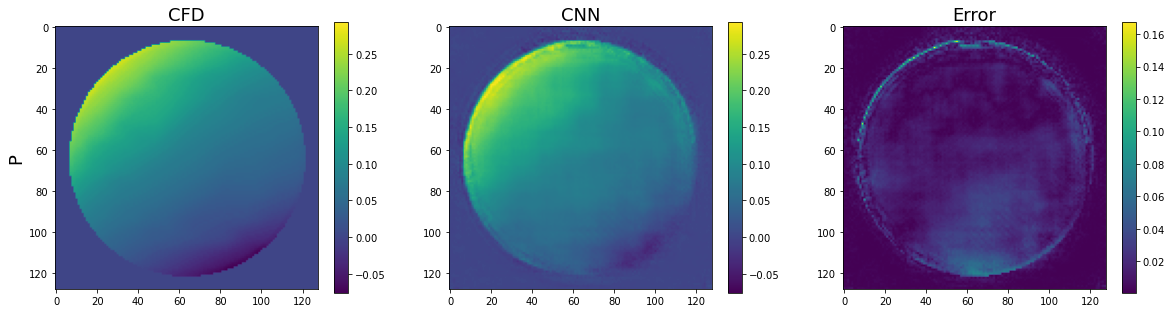

In [42]:
visualize(test_y.cpu().detach().numpy(),
          out.cpu().detach().numpy(),
          error.cpu().detach().numpy())

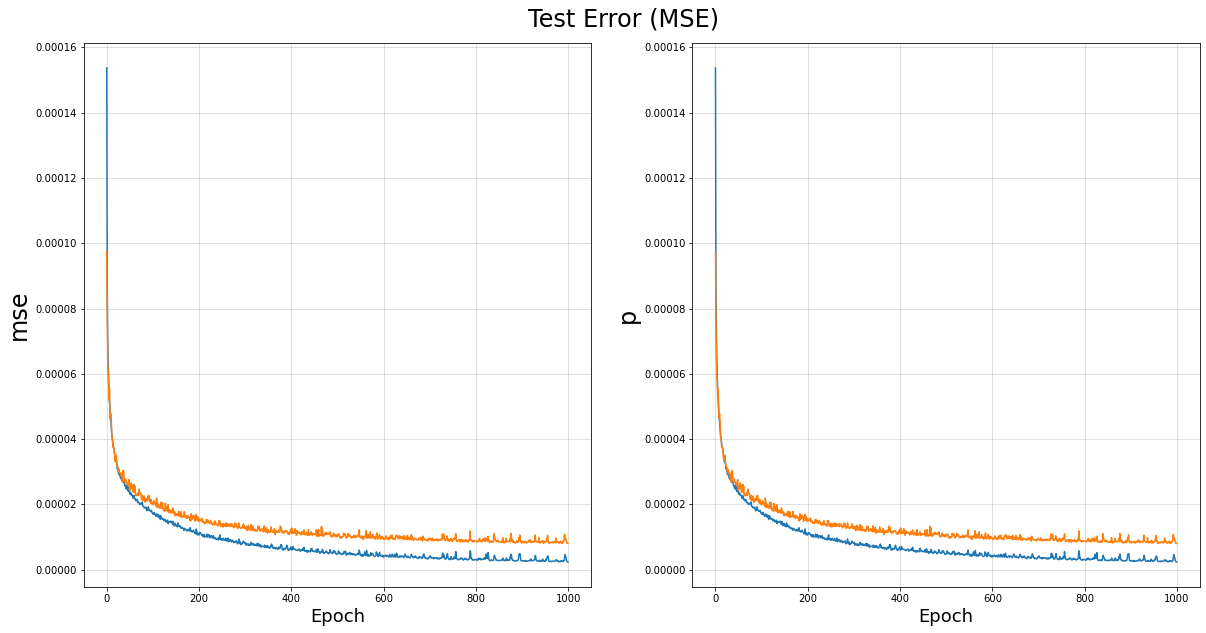

In [43]:
curve2plot = list(curves.keys())[2:]
n_plots = int(len(curve2plot)/2)
n_rows = int(math.ceil(n_plots/2))

fig, axs = plt.subplots(n_rows, 2, figsize=(20, n_rows*10))
fig.suptitle('Test Error (MSE)', y=0.93, fontsize=24)

for i in range(n_plots):
    axs[i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i%2].grid(alpha=0.5)
#     axs[i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i%2].set_xlabel('Epoch', fontsize=18)

plt.savefig(simulation_directory + 'MSE_ModelP.png')

# Inference

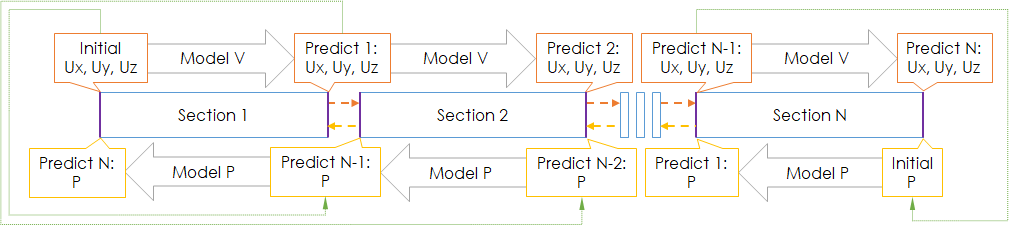

In [44]:
# loading data
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))

# # loading models
# MODEL_PATH = "D:/DataScience/FinalProject/"

# model_v = TheModelClass(*args, **kwargs)
# model_v.load_state_dict(torch.load(MODEL_PATH + 'model_v.pth'))
# model_v.eval()

# model_p = TheModelClass(*args, **kwargs)
# model_p.load_state_dict(torch.load(MODEL_PATH + 'model_p.pth'))
# model_p.eval()

#### Setting pipe param

##### Initial Velocity and Pressure

In [47]:
initial_velocity = []
initial_pressure = []

row = 0

for v in ['UX', 'UY', 'UZ']:
    img, _, _ = get_preprocessed_image(column='inlet-' + v + '_image', row=row)
    initial_velocity.append(img)

img, img_h, img_w = get_preprocessed_image(column='outlet-P_image', row=row)
initial_pressure.append(img)

In [69]:
initial_velocity[0] = initial_pressure[0]
initial_velocity[1] = initial_pressure[0]

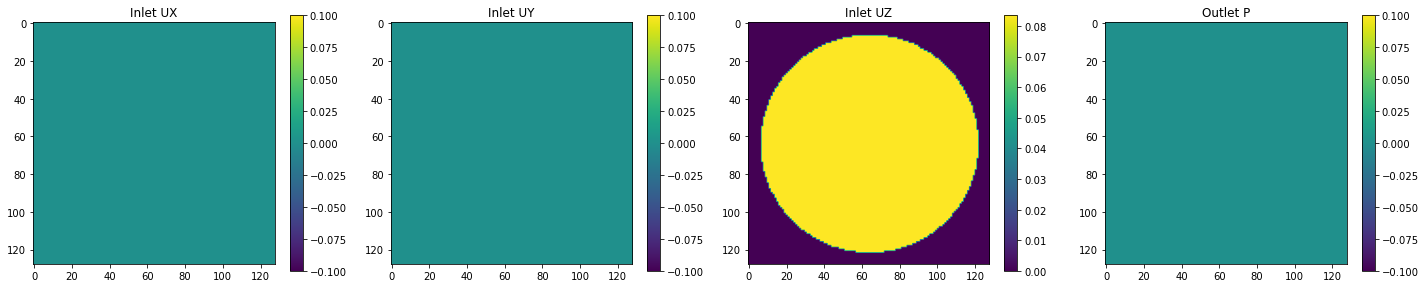

In [70]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(initial_velocity)+1):
    
    labels = ['UX', 'UY', 'UZ']
    
    if i == len(initial_velocity):
        img2plt = initial_pressure[0]
        title = 'Outlet P'
    else:
        img2plt = initial_velocity[i]
        title = 'Inlet ' + labels[i]
        
    plt.subplot(1, len(initial_velocity)+1, i+1)
    plt.imshow(img2plt)
    plt.title(title)
    plt.colorbar()

##### Pipe geom

In [71]:
'''
Available shapes:
    size = [50, 100],
    shape = [arc45, arc90, line],
    direction = [down, left, right, top]
    ---
    *If shape is "line" then direction can only be "left"
    **First section can only be "left
'''
# Input your geom
## section = [size, shape, direction]
pipe_config = {'section_1':['100','line','left'],
               'section_2':['50','arc45','top'],
               'section_3':['50','line','left'],
               'section_4':['100','arc90','right']}

In [72]:
# Converting to lable
geom_param_converter = {'previous':{'size':{'nothing':0,
                                            '50':1,
                                            '100':2},
                                    'shape':{'nothong':0,
                                             'arc45':1,
                                             'arc90':2,
                                             'line':3},
                                    'direction':{'nothong':0,
                                                 'left':1} },
                        
                        'current':{'size':{'50':0,
                                           '100':1},
                                   'shape':{'arc45':0,
                                            'arc90':1,
                                            'line':2},
                                   'direction':{'down':0,
                                                'left':1,
                                                'right':2,
                                                'top':3} },
                        
                        'next':{'size':{'nothing':0,
                                        '50':1,
                                        '100':2},
                                'shape':{'nothing':0,
                                         'arc45':1,
                                         'arc90':2,
                                         'line':3},
                                'direction':{'nothing':0,
                                             'down':0,
                                             'left':1,
                                             'right':2,
                                             'top':3} }
                       }

for i in pipe_config.keys():
    for j, k in enumerate(geom_param_converter['current'].keys()):
        pipe_config[i][j] = geom_param_converter['current'][k][pipe_config[i][j]]

In [73]:
# preparing geom channels

input_pipe_config = []

for i in range(len(pipe_config)):
    
    i = i+1
    
    section_geom_param = []
    
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    # previous
    if i == 1:
        section_geom_param += [0,0,0]
    else:
        section_geom_param += pipe_config['section_'+ str(i-1)]
    
    # current
    section_geom_param += pipe_config['section_'+ str(i)]
    
    # next
    if i == len(pipe_config):
        section_geom_param += [0,0,0]
    else:
        section_geom_param += pipe_config['section_'+ str(i+1)]
    
    print(section_geom_param)
    
    for (h, w), x in zip(itertools.product(range(img_h), range(img_w)), itertools.cycle(section_geom_param)):
        geom_param.itemset((h, w), x)
    
    input_pipe_config.append(geom_param.astype('float32'))

[0, 0, 0, 1, 2, 1, 0, 0, 3]
[1, 2, 1, 0, 0, 3, 0, 2, 1]
[0, 0, 3, 0, 2, 1, 1, 1, 2]
[0, 2, 1, 1, 1, 2, 0, 0, 0]


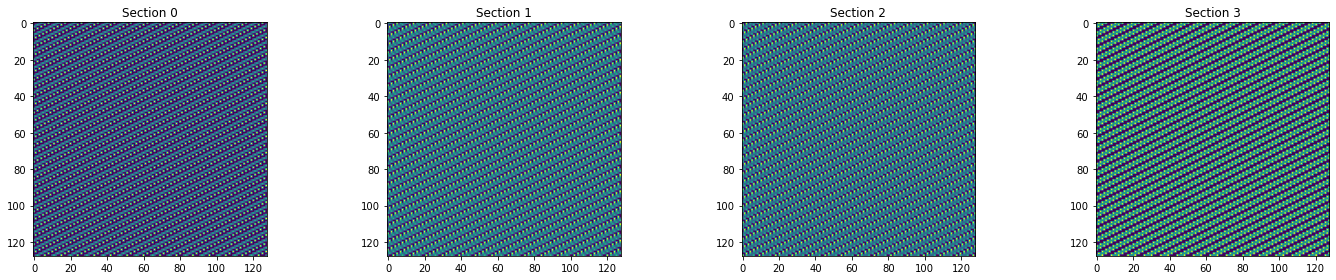

In [74]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(input_pipe_config)):
    plt.subplot(1, len(input_pipe_config), i+1)
    plt.imshow(input_pipe_config[i])
    plt.title('Section '+ str(i))

### Inferencing

In [75]:
model_v_out_list = []

for section in range(len(pipe_config)):
    
    channels_set = []
    all_sets = []
    
    if section == 0:
        channels_set = initial_velocity.copy()
    else:
        for v in range(len(initial_velocity)):
            channels_set.append(model_v_out[v])
        
    channels_set.append(input_pipe_config[section])
    
    all_sets.append(channels_set)
    
    all_sets = torch.FloatTensor(all_sets)

    # Predicting
    model_v_out = model_v(all_sets.to(device)).cpu().detach().numpy()[0]
    model_v_out_list.append(model_v_out)

In [76]:
f = open(simulation_directory + 'model_v_out.pkl', 'wb')
pickle.dump(model_v_out_list, f)

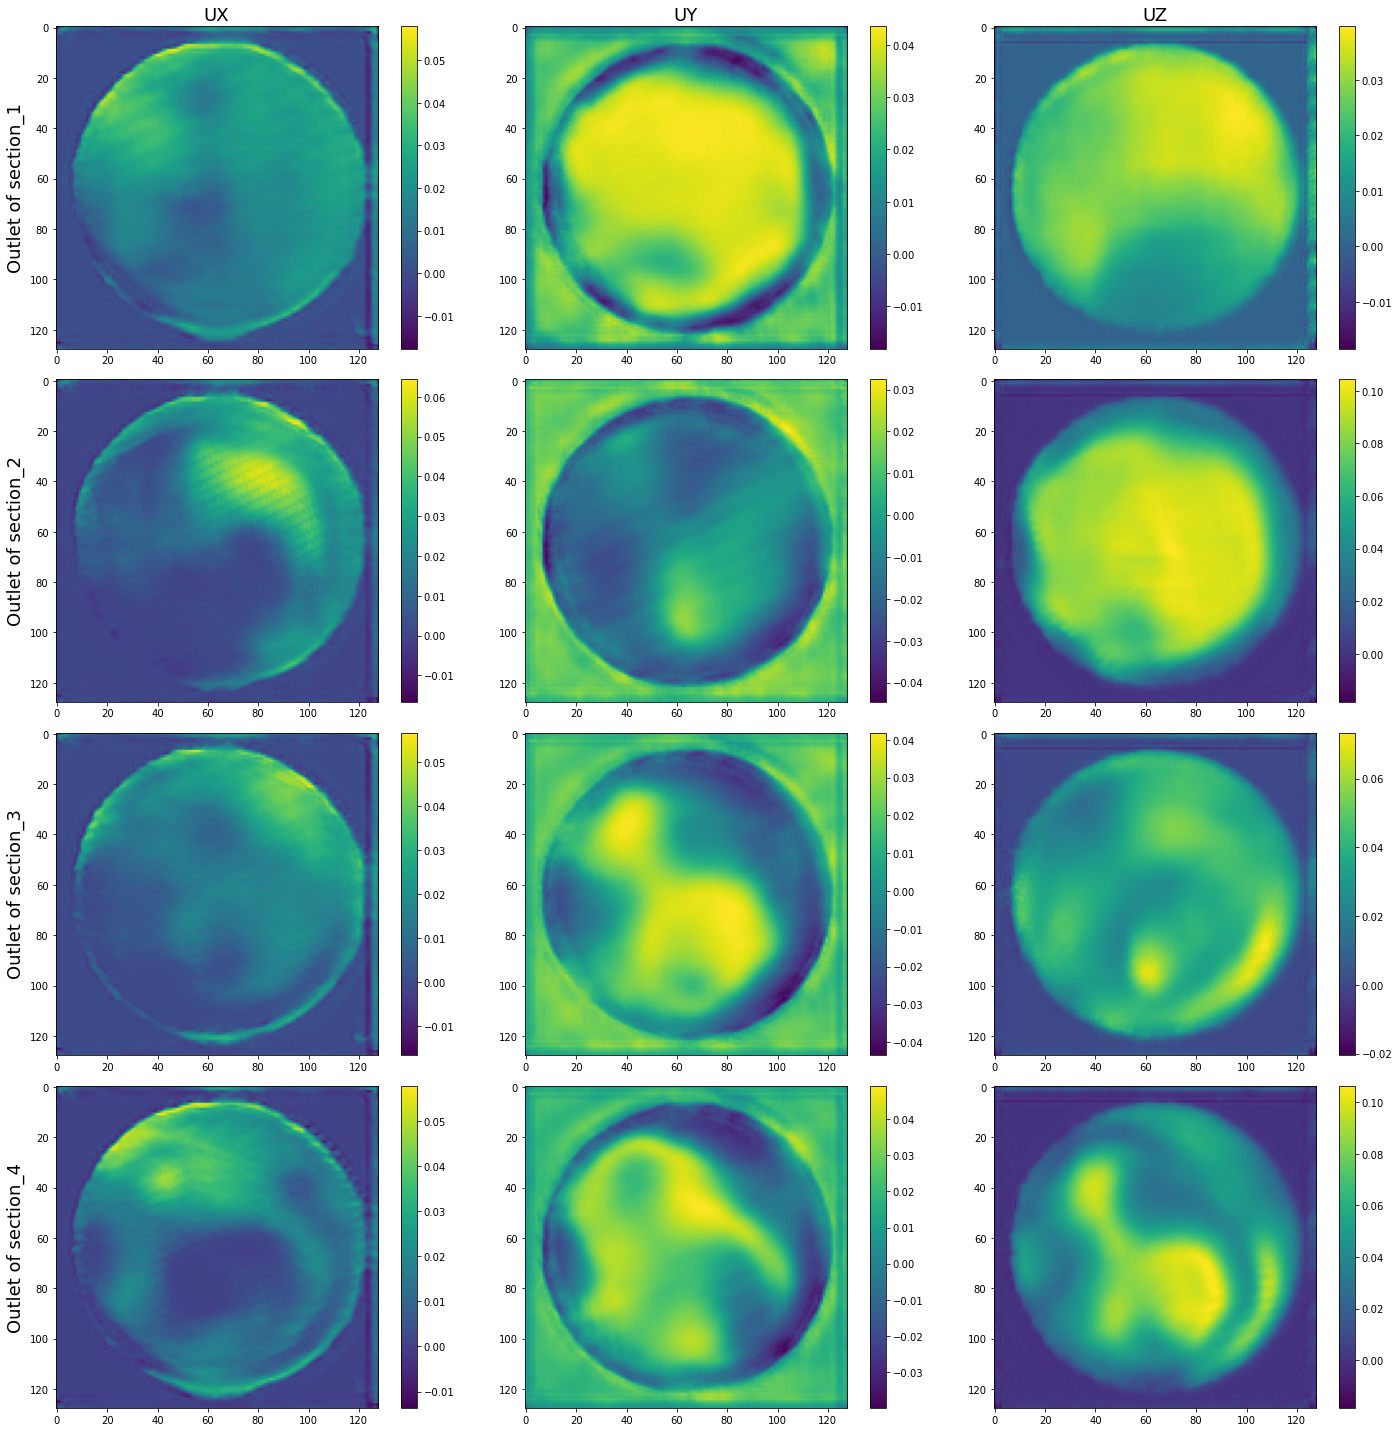

In [77]:
plt.figure(figsize=(20,20), tight_layout=True)

for cnt, (i, j) in enumerate(itertools.product(range(len(pipe_config)), range(3))):
    plt.subplot(len(pipe_config), 3, cnt+1)
    plt.imshow(model_v_out_list[i][j])
    
    if j == 0:
        plt.ylabel(f'Outlet of {list(pipe_config.keys())[i]}', fontsize=18)
    
    if i == 0:
        plt.title(f'{labels[j]}', fontsize=18)
    
    plt.colorbar()

In [78]:
model_p_out_list = []

for section in range(len(pipe_config)):
    
    channels_set = []
    all_sets = []
    
    if section == 0:
        channels_set = initial_pressure.copy()
    else:
        channels_set.append(model_p_out[0])
    
    if section == len(pipe_config)-1:
        velocity_set = initial_velocity.copy()
    else:
        velocity_set = model_v_out_list[len(pipe_config)-(2+section)].copy()
        
    for v in range(len(initial_velocity)):
        channels_set.append(velocity_set[v]) 
    
    all_sets.append(channels_set)
    
    all_sets = torch.FloatTensor(all_sets)

    # Prediction
    model_p_out = model_p(all_sets.to(device)).cpu().detach().numpy()[0]
    model_p_out_list.append(model_p_out)

In [79]:
f = open(simulation_directory + 'model_p_out.pkl', 'wb')
pickle.dump(model_p_out_list, f)

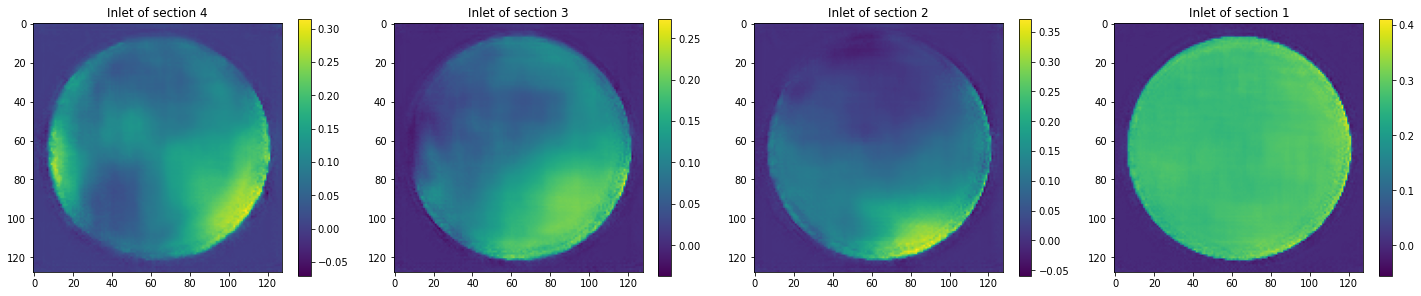

In [80]:
plt.figure(figsize=(20,4), tight_layout=True)

for i in range(len(pipe_config)):
    plt.subplot(1, len(pipe_config), i+1)
    plt.imshow(model_p_out_list[i][0])
    plt.title('Inlet of section '+ str(len(pipe_config)-i))
    plt.colorbar()

### CFD results

In [81]:
df_inference = pd.read_csv(os.path.join('D:/DataScience/FinalProject/inference/10-100-50-50-100', '10-100-50-50-100.csv'))
df_inference

description   s0-P_min  \
0  10-100-50-50-100-line-arc45-line-arc90-left-to...  37.754311   

   s0-UMagnitude_min  s0-UX_min  s0-UY_min  s0-UZ_min   s0-P_max  \
0                0.0        0.0        0.0  10.650389  42.437408   

   s0-UMagnitude_max  s0-UX_max  s0-UY_max  s0-UZ_max  s1-P_min  \
0          10.650389        0.0        0.0  10.650389 -4.723748   

   s1-UMagnitude_min  s1-UX_min  s1-UY_min  s1-UZ_min   s1-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s1-UMagnitude_max  s1-UX_max  s1-UY_max  s1-UZ_max  s2-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s2-UMagnitude_min  s2-UX_min  s2-UY_min  s2-UZ_min   s2-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s2-UMagnitude_max  s2-UX_max  s2-UY_max  s2-UZ_max  s3-P_min  \
0          11.773708   1.419527   8.618194  11.773708 -4.723748   

   s3-UMagnitude_min  s3-UX_min  s3-UY_min  s3-UZ_min   s3-P_max  \
0         -12.064829 -12.064829  -1.355771  -0.884109  42.437408   

   s3-UMagnitude_max  s3-UX_max  s3-UY_max  s3-UZ_max  s4-P_min  \
0          11.773708   1.419527   8.618194  11.773708       0.0   

   s4-UMagnitude_min  s4-UX_min  s4-UY_min  s4-UZ_min  s4-P_max  \
0         -12.064829 -12.064829  -1.316668  -0.798943       0.0   

   s4-UMagnitude_max  s4-UX_max  s4-UY_max  s4-UZ_max  
0           0.748225  -2.387443   0.697362   0.748225

In [82]:
IMG_PATH = 'D:\\DataScience\\FinalProject\\inference\\10-100-50-50-100\\10-100-50-50-100-line-arc45-line-arc90-left-top-left-right\\'

img_list = glob.glob(IMG_PATH + '*.png')

for img in img_list:
    new_column = os.path.basename(img).replace('.png', '_image')
    df_inference[new_column] = img

drop_list = []

for col in df_inference.columns:
    if 'Magnitude' in col:
        drop_list.append(col)

df_inference.drop(drop_list, axis=1, inplace=True)
df_inference

description   s0-P_min  s0-UX_min  \
0  10-100-50-50-100-line-arc45-line-arc90-left-to...  37.754311        0.0   

   s0-UY_min  s0-UZ_min   s0-P_max  s0-UX_max  s0-UY_max  s0-UZ_max  s1-P_min  \
0        0.0  10.650389  42.437408        0.0        0.0  10.650389 -4.723748   

   s1-UX_min  s1-UY_min  s1-UZ_min   s1-P_max  s1-UX_max  s1-UY_max  \
0 -12.064829  -1.355771  -0.884109  42.437408   1.419527   8.618194   

   s1-UZ_max  s2-P_min  s2-UX_min  s2-UY_min  s2-UZ_min   s2-P_max  s2-UX_max  \
0  11.773708 -4.723748 -12.064829  -1.355771  -0.884109  42.437408   1.419527   

   s2-UY_max  s2-UZ_max  s3-P_min  s3-UX_min  s3-UY_min  s3-UZ_min   s3-P_max  \
0   8.618194  11.773708 -4.723748 -12.064829  -1.355771  -0.884109  42.437408   

   s3-UX_max  s3-UY_max  s3-UZ_max  s4-P_min  s4-UX_min  s4-UY_min  s4-UZ_min  \
0   1.419527   8.618194  11.773708       0.0 -12.064829  -1.316668  -0.798943   

   s4-P_max  s4-UX_max  s4-UY_max  s4-UZ_max  \
0       0.0  -2.387443   0.697362   0.748225   

                                          s0-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s0-UZ_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                          s1-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s1-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s1-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s1-UZ_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                          s2-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s2-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s2-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s2-UZ_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                          s3-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s3-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s3-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s3-UZ_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                          s4-P_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UX_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UY_image  \
0  D:\DataScience\FinalProject\inference\10-100-5...   

                                         s4-UZ_image  
0  D:\DataScience\FinalProject\inference\10-100-5...

In [83]:
inference_img = []

for cross_sec in range(len(pipe_config)+1):
    
    cross_sec_img = []
    
    for col in df_inference.columns[-(len(pipe_config)+1)*4:]:
        if 's'+str(cross_sec) in col:
            img, _, _ = get_preprocessed_image(column=col, row=0, ratio=4, df=df_inference)
            cross_sec_img.append(img)
            
    inference_img.append(cross_sec_img)

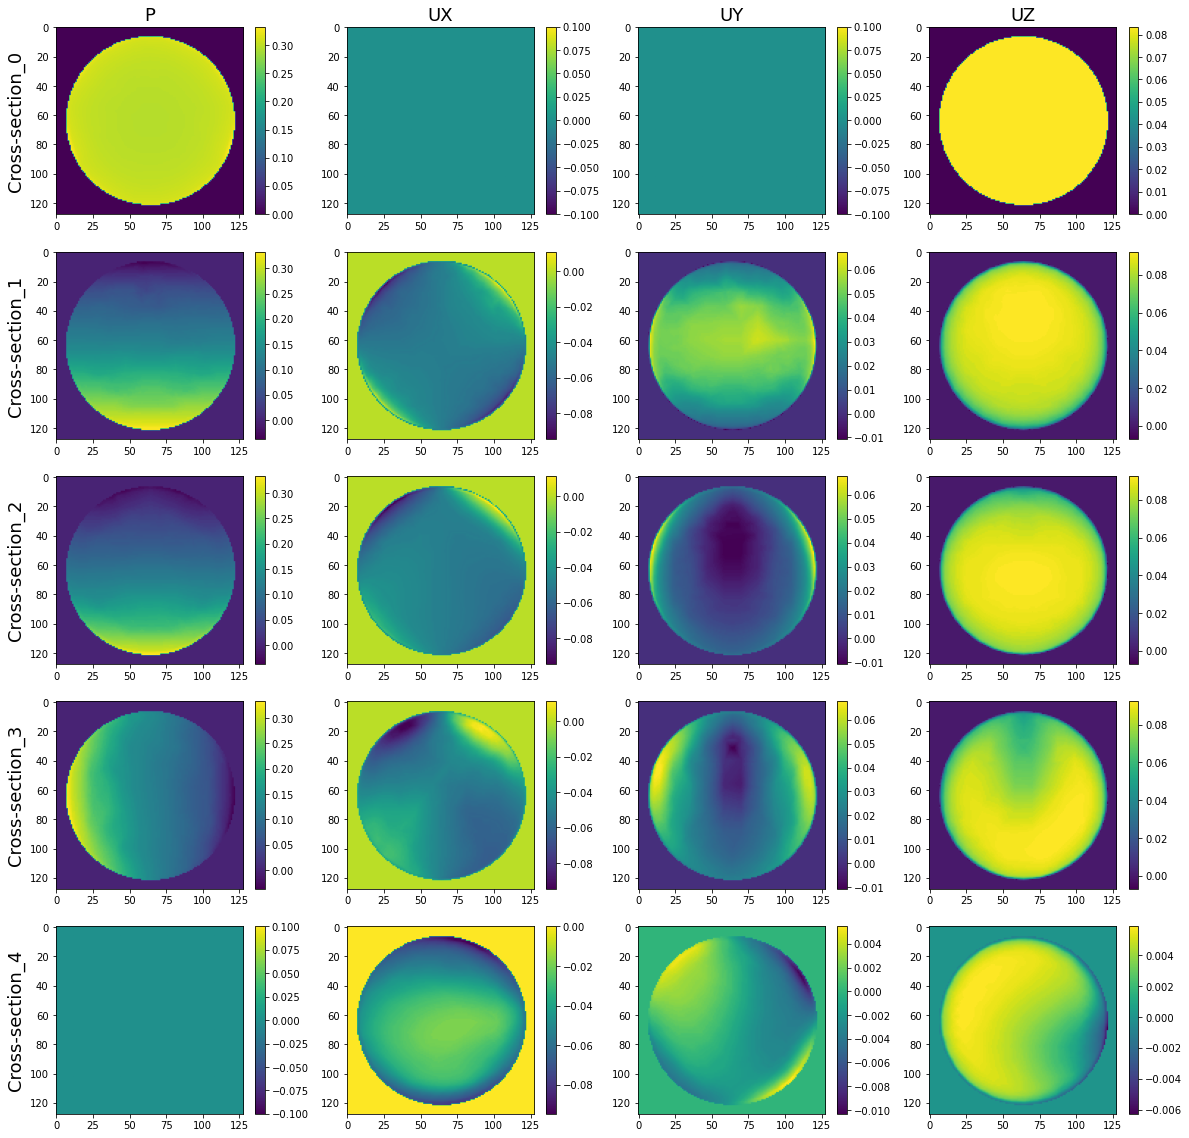

In [84]:
labels = ['P', 'UX', 'UY', 'UZ']

plt.figure(figsize=(20,20), tight_layout=False)

for cnt, (i, j) in enumerate(itertools.product(range(len(pipe_config)+1), range(len(labels)))):
    
    plt.subplot(len(pipe_config)+1, len(labels), cnt+1)
    plt.imshow(inference_img[i][j])
    
    if j == 0:
        plt.ylabel(f'Cross-section_{i}', fontsize=18)
    
    if i == 0:
        plt.title(f'{labels[j]}', fontsize=18)
    
    plt.colorbar()

# Comparison

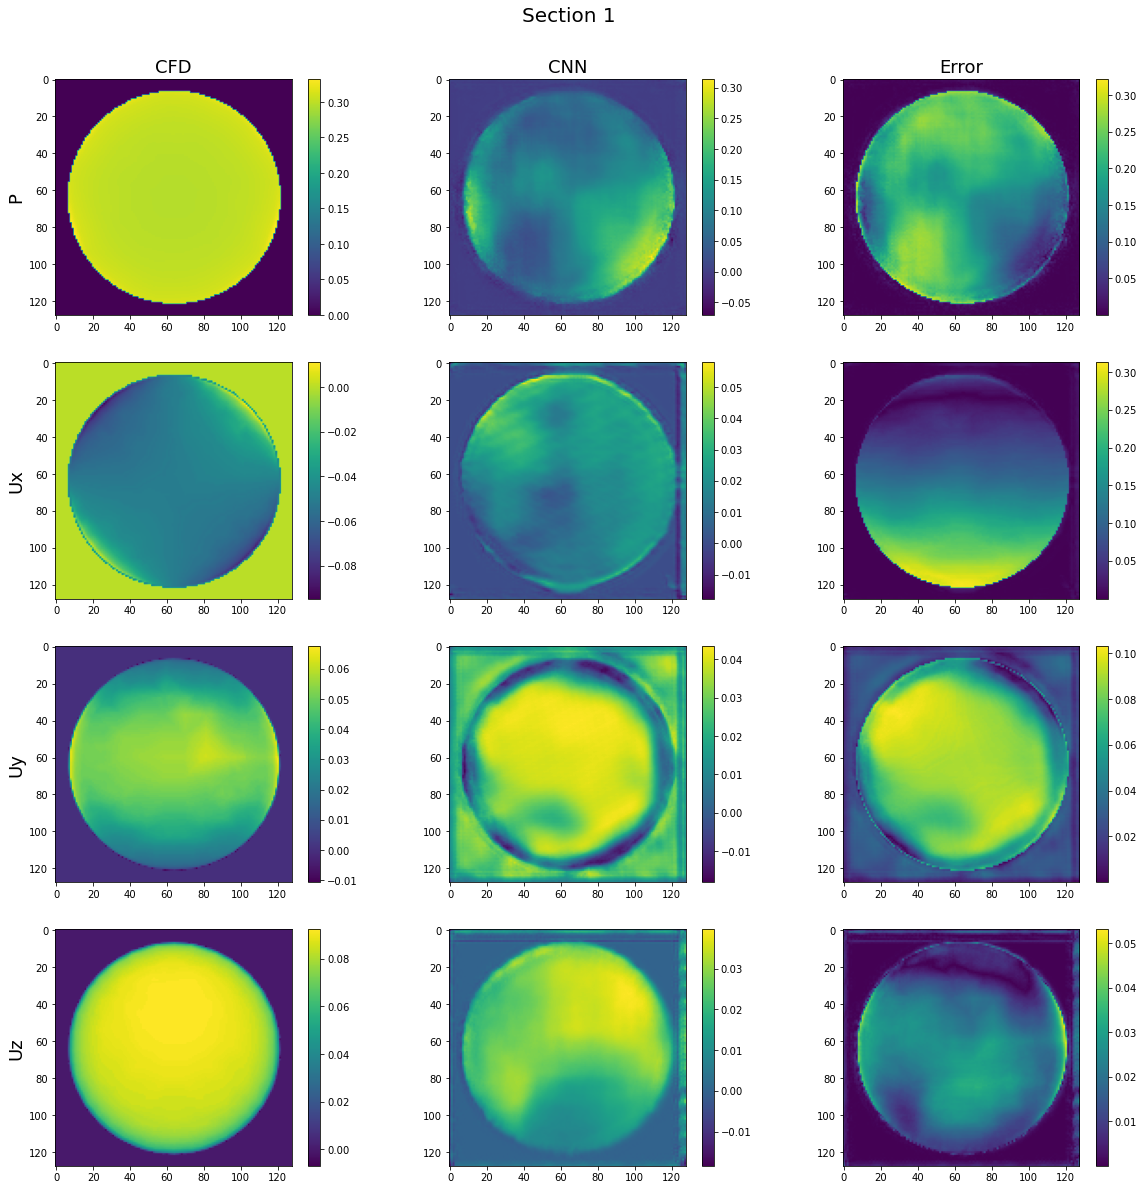

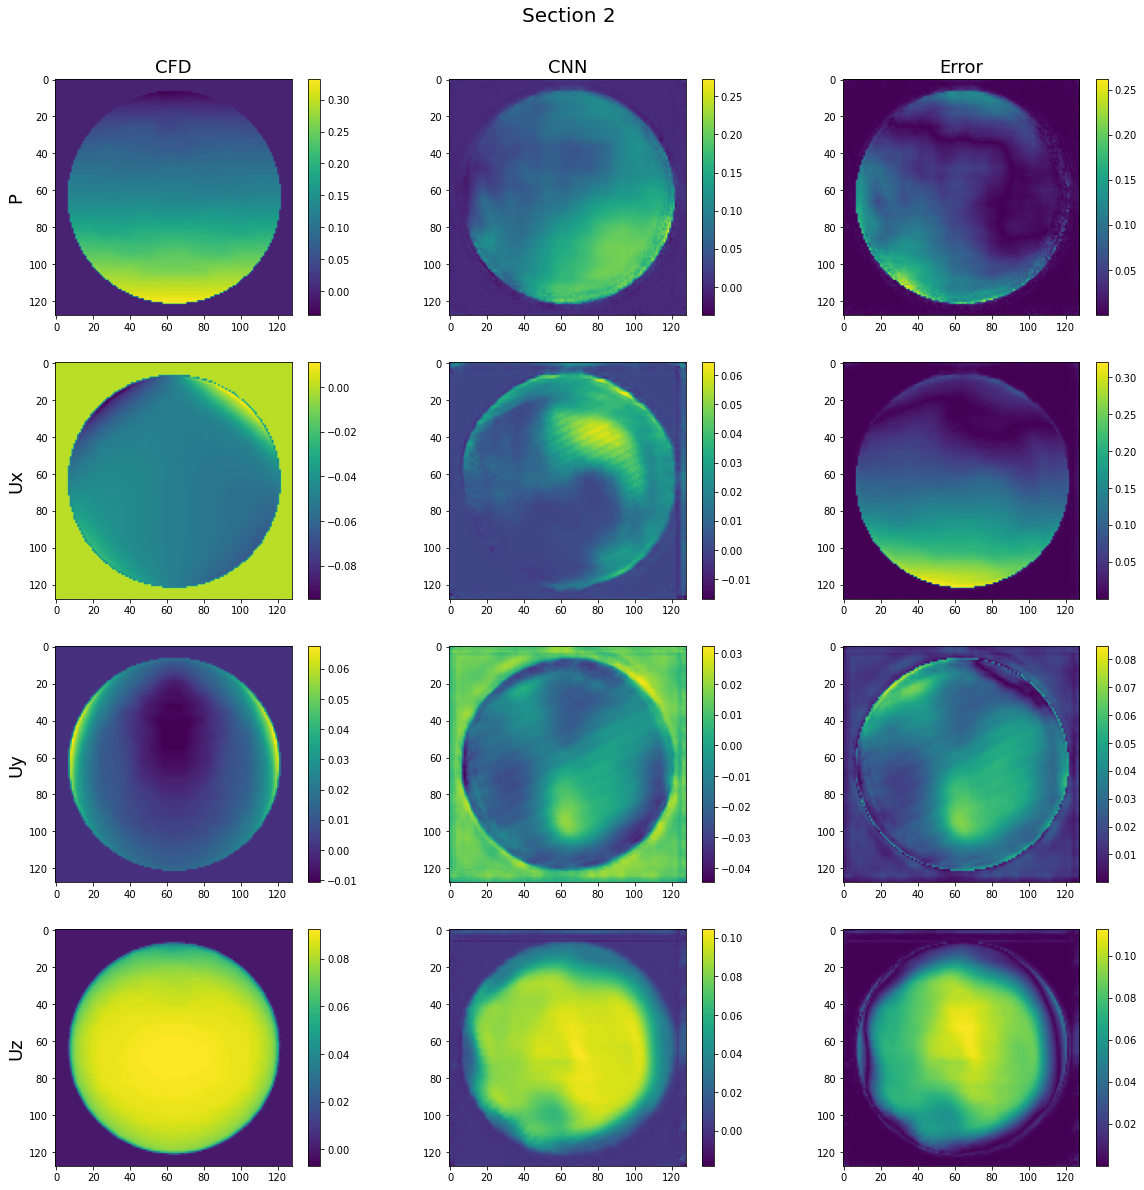

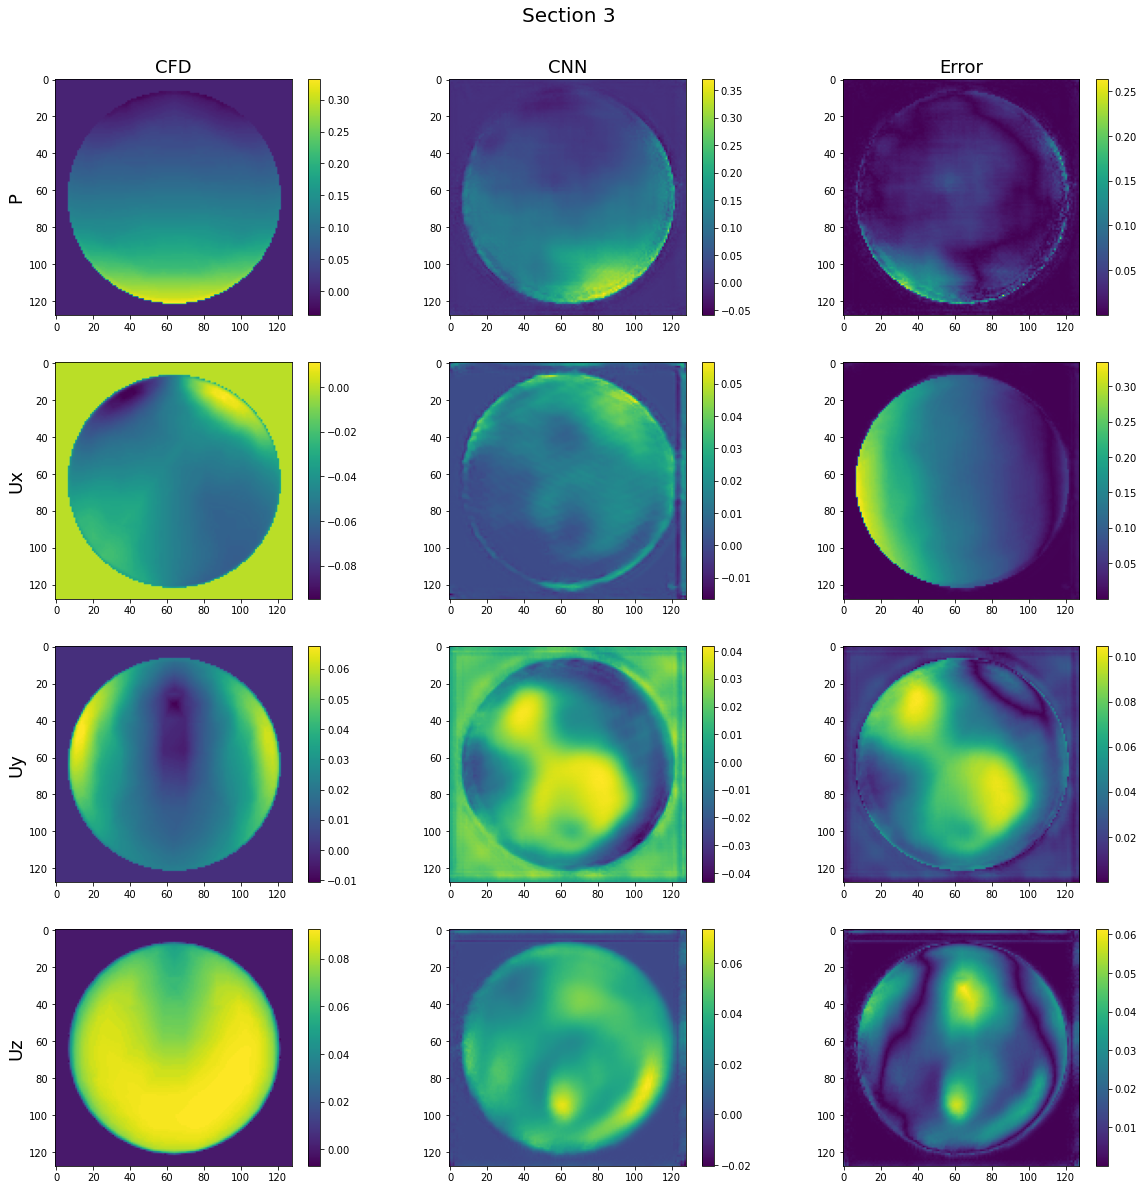

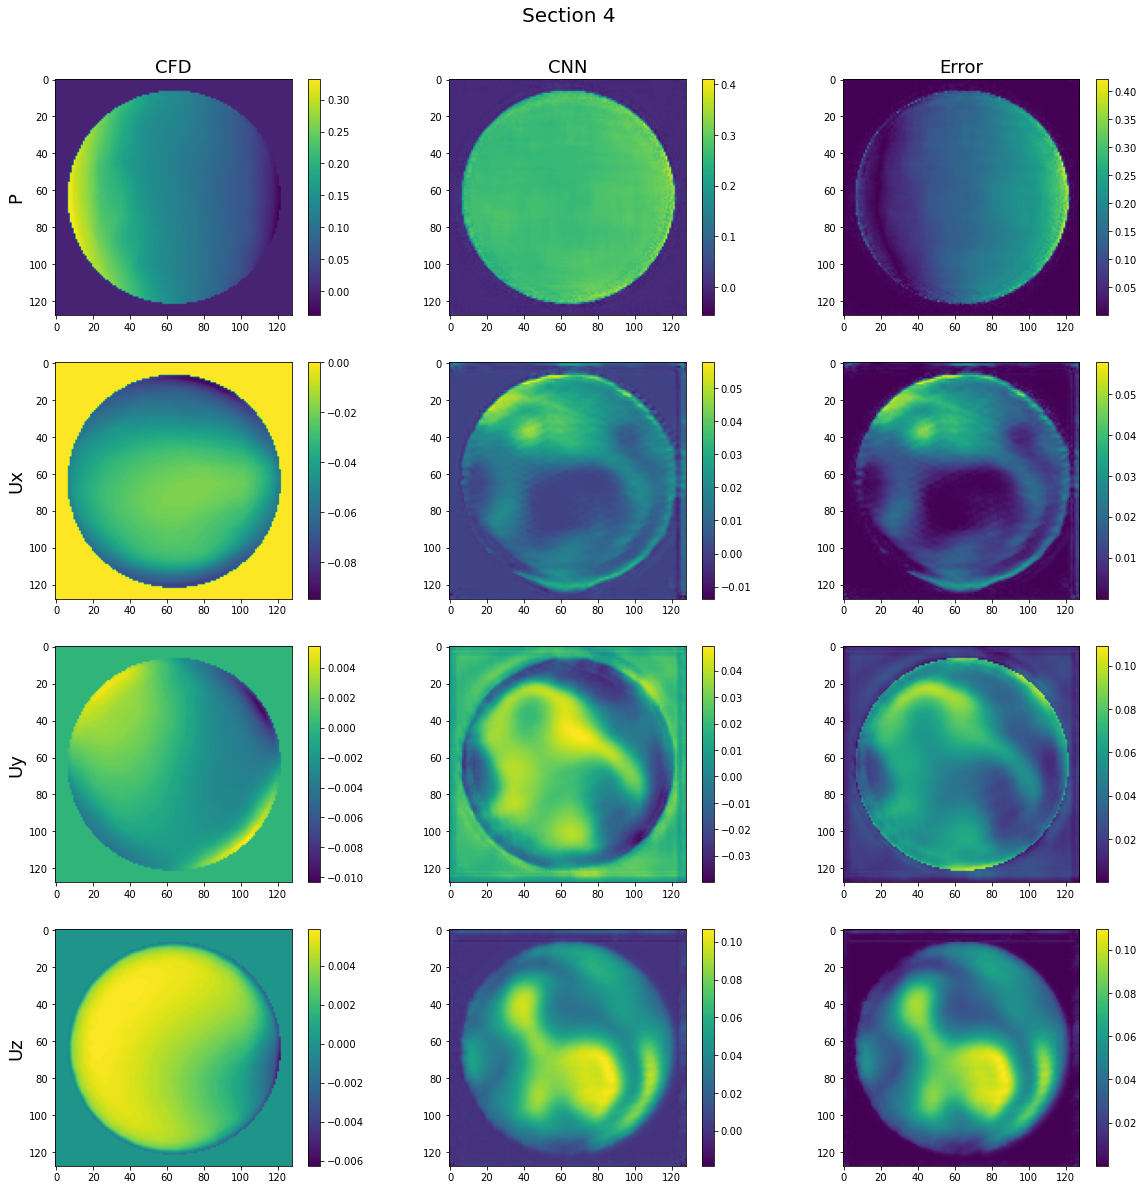

In [85]:
title_list = ['CFD', 'CNN', 'Error']
lable_list = ['P', 'Ux', 'Uy', 'Uz']

errs = []

for section in range(len(pipe_config)):
    
    section_err = []
    
    # pressure error
    section_err.append(np.absolute(model_p_out_list[section-len(pipe_config)][0] - inference_img[section][0]))
    
    # velocity error
    for v in range(3):
        err = np.absolute(model_v_out_list[section][v] - inference_img[section+1][v])
        section_err.append(err)
    
    # collecting
    errs.append(section_err)
    
    # plotting
    fig, axs = plt.subplots(len(lable_list), len(title_list), figsize=(20, 20))
    fig.suptitle(f'Section {section+1}', y=0.93, fontsize=20)
    
    for i in range(len(lable_list)):
        
        if i == 0:
            pcm_1 = axs[i][0].imshow(inference_img[section][0])
            pcm_2 = axs[i][1].imshow(model_p_out_list[section-len(pipe_config)][0])
        else:
            pcm_1 = axs[i][0].imshow(inference_img[section+1][i])
            pcm_2 = axs[i][1].imshow(model_v_out_list[section][i-1])
        
        pcm_3 = axs[i][2].imshow(section_err[i])

        for k, j in enumerate([pcm_1, pcm_2, pcm_3]):
            fig.colorbar(j, ax=axs[i][k])
            if i == 0:
                axs[i][k].set_title(f'{title_list[k]}', fontsize=18)
            if k == 0:
                axs[i][k].set_ylabel(f'{lable_list[i]}', fontsize=18)

In [86]:
# model_v_err = []

# for v in range(3, 0, -1):
#     err = np.absolute(model_v_out_list[-1][-v] - inference_image[-v])
#     model_v_err.append(err)

In [87]:
# model_p_err = np.absolute(model_p_out_list[-1][0] - inference_image[0])

In [88]:
# fig, axs = plt.subplots(len(model_v_err)+1, 3, figsize=(20, 20))
# # fig.suptitle('Comparison', y=0.93, fontsize=20)

# title_list = ['CFD', 'CNN', 'Error']
# lable_list = ['Ux', 'Uy', 'Uz', 'P']

# for i in range(len(model_v_err)+1):
#     if i != len(model_v_err):
#         pcm_1 = axs[i][0].imshow(inference_image[i-3])
#         pcm_2 = axs[i][1].imshow(model_v_out_list[-1][i])
#         pcm_3 = axs[i][2].imshow(model_v_err[i])
#     else:
#         pcm_1 = axs[i][0].imshow(inference_image[0])
#         pcm_2 = axs[i][1].imshow(model_p_out_list[-1][0])
#         pcm_3 = axs[i][2].imshow(model_p_err)

#     for k, j in enumerate([pcm_1, pcm_2, pcm_3]):
#         fig.colorbar(j, ax=axs[i][k])
#         if i == 0:
#             axs[i][k].set_title(f'{title_list[k]}', fontsize=18)
#         if k == 0:
#             axs[i][k].set_ylabel(f'{lable_list[i]}', fontsize=18)

In [89]:
# plt.figure(figsize=(20,4), tight_layout=True)

# for i in range(len(model_v_err)+1):
    
#     if i == len(model_v_err):
#         img2plt = model_p_err
#         title = 'Error P'
#     else:
#         img2plt = model_v_err[i]
#         title = 'Error ' + labels[i]
        
#     plt.subplot(1, len(model_v_err)+1, i+1)
#     plt.imshow(img2plt)
#     plt.title(title)
#     plt.colorbar()